In [1]:
import os
import os.path as op
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from scipy.ndimage import measurements

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

import mne
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm
from mne.decoding import CSP
from library import helpers, config

# TODO: extract values for manuscript:
# - latalpha_cbp_2ndlvl_pval
# - 

In [47]:
%load_ext autoreload
%autoreload 2

In [147]:
# %%
def get_epos(subID, epo_part, signaltype, condition, event_dict):
    if signaltype == 'uncollapsed':
        fname = op.join(config.path_rejepo, subID + '-' + epo_part +
                        '-postica-rejepo' + '-epo.fif')
    elif signaltype in ['collapsed']:
        fname = op.join(config.path_epos_sorted, epo_part, signaltype,
                        subID + '-epo.fif')
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)

def get_sensordata(subID, epo_part, signaltype, conditions, event_dict):
    epos_dict = defaultdict(dict)
    for cond in conditions:
        epos_dict[cond] = get_epos(subID,
                                   epo_part=epo_part,
                                   signaltype=signaltype,
                                   condition=cond,
                                   event_dict=event_dict)

    times = epos_dict[conditions[0]][0].copy().times

    # Setup data:
    X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
    n_ = {cond: len(epos_dict[cond]) for cond in conditions}

    times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X_epos, y, times_n


def load_avgtfr(subID, condition, pwr_style='induced', 
                epo_part='fulllength', baseline=None, mode=None): 
    fpath = op.join(config.paths['05_tfrs'], pwr_style, 'tfr_lists', epo_part)
    fname = op.join(fpath, subID + '-collapsed-avgTFRs-tfr.h5')
    tfr_ = mne.time_frequency.read_tfrs(fname, condition=condition)
    if baseline is not None:
        tfr_.apply_baseline(baseline=baseline, mode=mode)
    return tfr_


def plot_tfr_side(ax, tfr, picks, cbar=True, tmin=None, tmax=None, 
                  vmin=None, vmax=None, title='', cmap='RdBu_r', mask=None):
        ha = tfr.copy().crop(tmin, tmax).plot(axes=ax, 
                                      show=False,
                                      baseline=(-1.1,-0.9),
                                      mode='mean', 
                                      colorbar=cbar,
                                      picks=picks, 
                                      combine='mean', 
                                      title=title, 
                                      #vmax=vmax, 
                                      #vmin=vmin, 
                                      cmap=cmap,
                                      mask=mask)
        ytick_range = ax.get_ylim()
        ytick_vals = np.arange(*np.round(ytick_range), 2)
        ax.yaxis.set_ticks(ytick_vals)
        ax.axvspan(0, 0.2, color='grey', alpha=0.3)
        ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
        ax.vlines((-0.8, 0, 0.2, 2.2), ymin=-1000, ymax=10000, linestyles='dashed')
        #ax.set_title('uV^2/Hz')
        return ha

def get_lateralized_power_difference(pwr_, picks_contra, picks_ipsi):
    if not len(picks_contra) == len(picks_ipsi):
        raise ValueError('Picks must be of same length.')
    pwr_diff = pwr_.copy().pick_channels(picks_contra, ordered=True)
    pwr_ordered_chans = pwr_.copy().reorder_channels(picks_contra + picks_ipsi)
    # keep flexible to use for data with 3 (AvgTFR) and 4 (EpoTFR) dimensions: 
    d_contra = pwr_ordered_chans._data[..., :len(picks_contra), :, :]
    d_ipsi = pwr_ordered_chans._data[..., len(picks_contra):, :, :]
    pwr_diff._data = d_contra - d_ipsi
    return pwr_diff


def run_cbp_test(data, p_initial = 0.05, p_thresh = 0.05):
    # number of permutations to run
    n_permutations = 1000 
    # set initial threshold
    p_initial = p_initial
    # set family-wise p-value
    p_thresh = p_thresh
    adjacency = None
    tail = 0.  # for two sided test

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = permutation_cluster_1samp_test(
        data, threshold=threshold, n_jobs=config.n_jobs, verbose=True, tail=tail,
        step_down_p=0.05, adjacency=adjacency,
        n_permutations=n_permutations, seed=42)

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)


def plot_cbp_result(ax, T_obs, clusters, cluster_p_values, p_thresh, 
                        cbp_times=None, times_full=None):
    if cbp_times is None:
        if times_full is None: 
            times_full = range(len(T_obs))
        cbp_times = times_full
    if times_full is None: 
        times_full = cbp_times
    y_max = np.max(np.abs(T_obs)) * np.array([-1.1, 1.1])
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] < p_thresh:
            h1 = ax.axvspan(cbp_times[c[0]], cbp_times[c[- 1]],
                            color='r', alpha=0.3)
    hf = ax.plot(cbp_times, T_obs, 'g')
    ax.hlines(0, times_full[0], times_full[-1])
    ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1, prop={'size': 9})
    ax.set(xlabel="Time (s)", ylabel="T-values",
            ylim=y_max, xlim=times_full[np.array([0,-1])])
    #fig.tight_layout(pad=0.5)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    ax.vlines([-0.8, 0,0.2,2.2], *y_max, linestyles='--', colors='k',
                    linewidth=1., zorder=1)
    #ax.set_aspect(0.33)
    ax.set_title('')
    #ax.set_aspect('auto', adjustable='datalim')
    #ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)


def plot_main_eff(cond, cond_dict, data, ax, n_boot=1000):
    sns.lineplot(x='time', y='pwr', hue=cond, data=data, n_boot=n_boot, 
                 palette=[config.colors[l] for l in cond_dict[cond]], ax=ax)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(-1.1, 2.3), ylim=ytick_range)
    ax.set_ylabel('V$^2$')
    ax.set_xlabel('Time (s)')
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
    ax.vlines((-0.8, 0, 0.2, 2.2), ymin=ytick_range[0], ymax=ytick_range[1], 
            linestyles='dashed')
    ax.hlines(0, xmin=-1.1, xmax=2.3)



def get_tfr(epos, picks='all', average=True, freqs=None):
    if freqs is None:
        freqs = np.concatenate([np.arange(6, 26, 1)])  # , np.arange(16,30,2)])
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power = mne.time_frequency.tfr_morlet(epos, picks=picks, freqs=freqs,
                                          n_cycles=n_cycles, use_fft=True,
                                          return_itc=False, average=average,
                                          decim=1, n_jobs=-2)
    return power


def get_mean_pwrdiff_per_trial(subID, freqs_to_avg=np.arange(8,13),
                               t_start=None, t_stop=None, pwr_style='induced',
                               epo_part='fulllength', 
                               picks=config.chans_CDA_all):
    fpath = op.join(config.paths['03_preproc-pooled'], epo_part, 'collapsed')
    epos_ = helpers.load_data(f'{subID}-{epo_part}-collapsed',
                              fpath, '-epo')
    
    # Shift time, so that 0 == Stimulus Onset:
    epos_ = epos_.shift_time(-config.times_dict['cue_dur'])
    
    if pwr_style == 'induced':
        epos_ = epos_.subtract_evoked()

    event_dict = helpers.get_event_dict(epos_.event_id)

    sub_dfs = list()

    for load in ['LoadLow', 'LoadHigh']:
        for ecc in ['EccS', 'EccM', 'EccL']:
            epos_cond = epos_[event_dict[load]][event_dict[ecc]]
            # Get TFRs and calc lat power:
            tfrs_cond = get_tfr(epos_cond,
                                   picks=picks, 
                                   average=False, 
                                   freqs=freqs_to_avg)
            tfrs_cond.apply_baseline(baseline=(-(config.times_dict['cue_dur']+0.3), 
                                               -(config.times_dict['cue_dur']+0.1)), 
                                     mode='mean')
            tfr_lat = get_lateralized_power_difference(tfrs_cond, 
                                                       config.chans_CDA_dict['Contra'], 
                                                       config.chans_CDA_dict['Ipsi'])
            # Crop to cluster times: 
            tfr_lat.crop(t_start, t_stop)
            tfr_lat_df = tfr_lat.to_data_frame()
            tfr_lat_df = tfr_lat_df.loc[:, ['epoch'] + tfr_lat.ch_names]
            tfr_lat_df = tfr_lat_df.groupby('epoch').agg('mean').reset_index()
            tfr_lat_df['mean_pwr_diff'] = tfr_lat_df.loc[:, tfr_lat.ch_names].mean(axis=1)
            tfr_lat_df['c_StimN'] = load
            tfr_lat_df['c_Ecc'] = ecc
            tfr_lat_df['trial_num'] = tfr_lat_df.epoch# [trial_nums[i] for i in tfr_lat_df.epoch]
            tfr_lat_df = tfr_lat_df.drop('epoch', axis=1)
            
            # store in list
            sub_dfs.append(tfr_lat_df)

    sub_df = pd.concat(sub_dfs, axis=0)
    sub_df['subID'] = subID
    return(sub_df)


def get_condition_pwrdiff_df(factor, cond_dict, sub_list_str, pwr_style="induced", epo_part="fulllength"):
    df_list = list()
    for cond in cond_dict[factor]:
        tfr_list = [load_avgtfr(subID, cond, pwr_style, epo_part, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                            -(config.times_dict['cue_dur']+0.1)), 
                    mode='mean') for subID in sub_list_str]

        diffs_ = [get_lateralized_power_difference(tfr, 
                                                config.chans_CDA_dict['Contra'], 
                                                config.chans_CDA_dict['Ipsi']) for 
                tfr in tfr_list]

        frqs_idx = [(8 <= diffs_[0].freqs) & (diffs_[0].freqs <= 13)]
        diffs_mean = [d.data[:, frqs_idx[0], :].mean(axis=(0, 1)) for d in diffs_]
        plt_df = pd.DataFrame(np.array(diffs_mean).swapaxes(1, 0),
                              columns=sub_list_str)
        plt_df['time'] = times
        plt_df[factor] = cond
        df_list.append(plt_df)

    df_load_concat = pd.concat(df_list)
    df_load_long = df_load_concat.melt(id_vars=['time', factor], 
                                       var_name='subID', 
                                       value_name='pwr')
    return(df_load_long)

## Loading the TFRs from disc

Running the next two cells will take quite long. Then you have the TFRs in memory and can fairly quickly work with them. 


In [3]:
#%%
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

part_epo = 'fulllength'
pwr_style = 'induced'  # 'evoked' # 
cond_dict = {'Load': ['LoadLow', 'LoadHigh'], 
             'Ecc': ['EccS', 'EccM', 'EccL']}


#%% get list with avg TFRs for all trials and conditions: !!! THIS BLOCK TAKES AGES
tfr_list = [load_avgtfr(subID, 'all', pwr_style, part_epo, 
                        baseline=(-(config.times_dict['cue_dur']+0.3), 
                                  -(config.times_dict['cue_dur']+0.1)), 
                        mode='mean') 
            for subID in sub_list_str]

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/

In [5]:
cond_dict

{'Load': ['LoadLow', 'LoadHigh'], 'Ecc': ['EccS', 'EccM', 'EccL']}

In [4]:
#%% get dict with avg TFRs per load and eccentricity condition: !!! THIS BLOCK TAKES EVEN LONGER
all_conds = [c for fac in cond_dict for c in cond_dict[fac]]
tfr_by_cond = {cond: [load_avgtfr(subID, cond, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                                -(config.times_dict['cue_dur']+0.1)), 
                    mode='mean') 
                    for subID in sub_list_str]
               for cond in all_conds}

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/

Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S07-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptm

Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S07-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S08-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S09-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /raven/ptm

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Applying baseline correction (mode: mean)


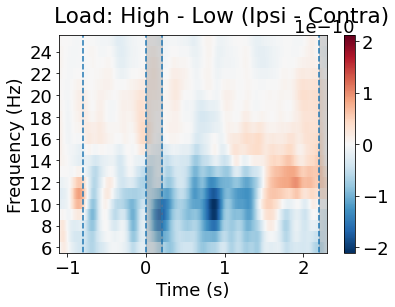

In [11]:
# Calculate the grand average:
grand_avgtfr_all = mne.grand_average(tfr_list)

#%% Set up params:
times = grand_avgtfr_all.times
freqs = grand_avgtfr_all.freqs



First, we plot the TFR per "hemisphere" (i.e., the ROI on the contralateral and the ipsilateral side);

Applying baseline correction (mode: mean)
creating dir: /raven/ptmp/fklotzsche/Experiments/vMemEcc/Plots2022/TFR/fulllength
Applying baseline correction (mode: mean)


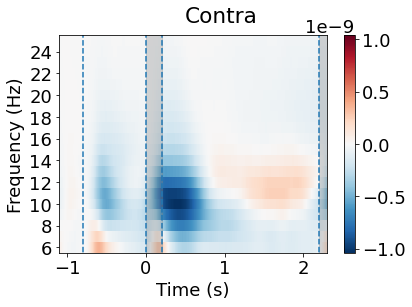

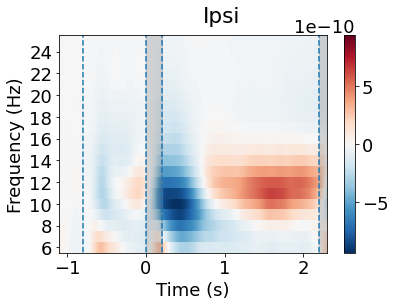

In [14]:
# Plot TF diag per hemisphere across all conditions:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams['font.size'] = 18
for side in ['Contra', 'Ipsi']:
    fig, ax = plt.subplots(1, figsize=(6,4))
    tf_contra = plot_tfr_side(ax, grand_avgtfr_all, picks=config.chans_CDA_dict[side], 
                tmin=-1.1, tmax=2.3, title=side, cbar=True, 
                vmin=-6e-10, vmax=6e-10)

    # Save it: 
    fpath = op.join(config.paths["plots"], 'TFR', part_epo)
    helpers.chkmk_dir(fpath)
    fname = op.join(fpath, f'grandavgTFR_{side}.svg')
    fig.savefig(fname, bbox_inches="tight")

Next step: we calculate the lateralized TFR (i.e., the difference between the two hemispheres):

In [15]:
#%% Calculate the difference between the hemispheres:
diff_avgtfr_all = get_lateralized_power_difference(grand_avgtfr_all, 
                                                 config.chans_CDA_dict['Contra'], 
                                                 config.chans_CDA_dict['Ipsi'])


Applying baseline correction (mode: mean)


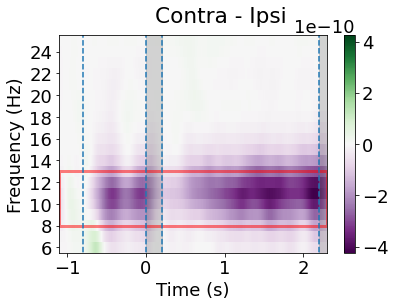

In [192]:
fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_avgtfr_all, picks='all', 
            tmin=-1.1, tmax=2.3, title='Contra - Ipsi', cbar=True, 
            vmin=-4e-10, vmax=4e-10, cmap='PRGn')

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference.svg')
fig.savefig(fname, bbox_inches="tight")

# Create version with red box around classical alpha range (8-12Hz):
rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=3, edgecolor='r', facecolor='none', alpha=0.5)
ax.add_patch(rect)
# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference_classAlpha.svg')
fig.savefig(fname, bbox_inches="tight")

We run a CBP test to produce a masked (thresholded) version of this plot, showing only the significant clusters (p <.05):

In [190]:
cropped_data = np.array([d.copy().crop(-1.1, 2.3).data.mean(axis=0) for d in diffs_avgtfr_all])
adjacency = mne.stats.combine_adjacency(*cropped_data.shape[-2:])
threshold = None  # let MNE calc threshold
n_permutations = 1000  
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(cropped_data, n_permutations=n_permutations,
                                   threshold=threshold, tail=0,
                                   adjacency=adjacency,
                                   out_type='mask', verbose=True,
                                   n_jobs=-2)

T_obs_mask = np.full(T_obs.shape, False)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        T_obs_mask[c] = True

Using a threshold of 2.085963
stat_fun(H1): min=-4.681591 max=3.339622
Running initial clustering
Found 13 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


Applying baseline correction (mode: mean)


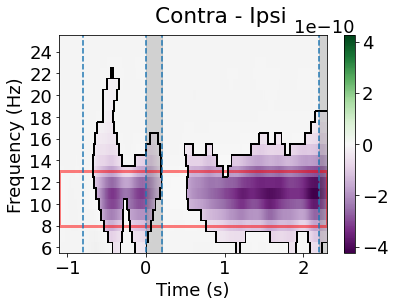

In [193]:
fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_avgtfr_all, picks='all', 
            tmin=-1.1, tmax=2.3, title='Contra - Ipsi', cbar=True, 
            vmin=-4e-10, vmax=4e-10, cmap='PRGn', mask=T_obs_mask)

# Add red box around classical alpha range (8-12Hz):
rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=3, edgecolor='r', facecolor='none', alpha=0.5)
ax.add_patch(rect)
# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'grandavgTFR_Difference_classAlpha_masked.svg')
fig.savefig(fname, bbox_inches="tight")

We produce one of these plots per participant to check for consistency:

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


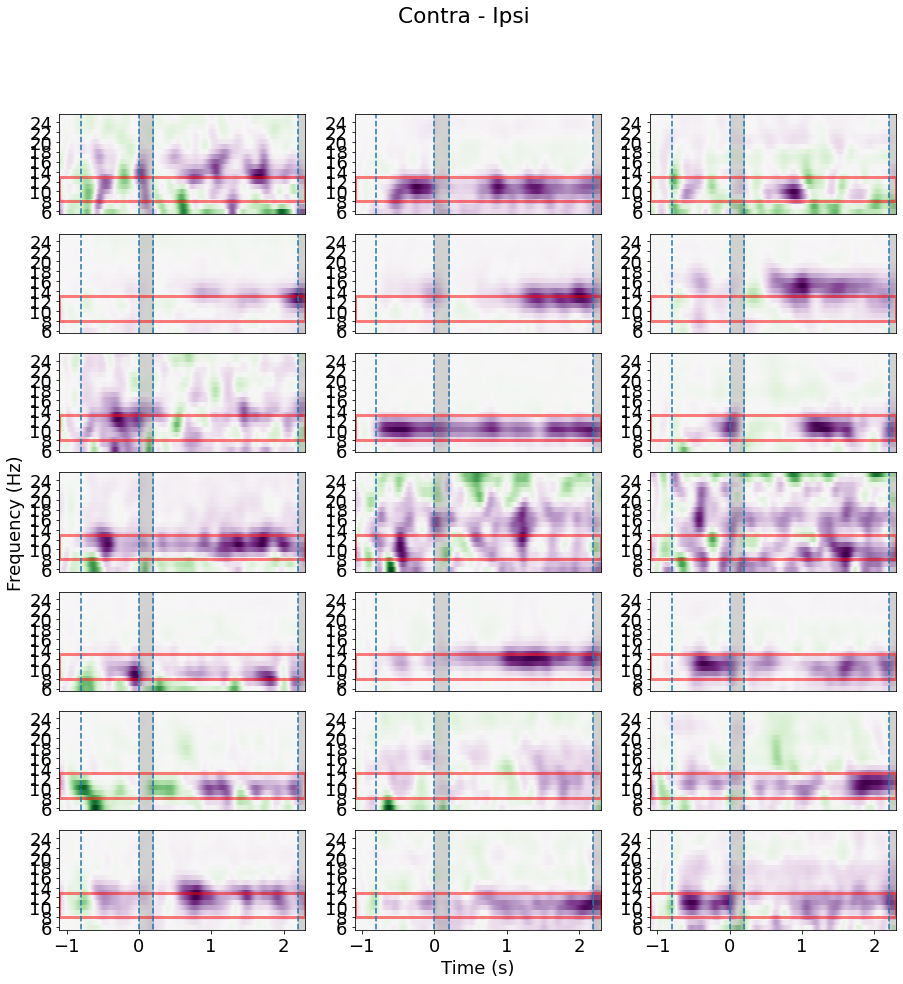

In [46]:

#%% Get the difference per subject: 

diffs_avgtfr_all = [get_lateralized_power_difference(tfr, 
                                                   config.chans_CDA_dict['Contra'], 
                                                   config.chans_CDA_dict['Ipsi']) for 
                    tfr in tfr_list]


##############################################################################################
#%% Make single subject plots:
fig, ax = plt.subplots(7,3, figsize=(15,15))
for tfr_, ax_ in zip(diffs_avgtfr_all, ax.reshape(-1)):
    plot_tfr_side(ax_, tfr_, picks='all', 
            tmin=-1.1, tmax=2.3, title='Contra - Ipsi', cbar=False, 
            cmap='PRGn')
    rect = mpl.patches.Rectangle((-1.1, 8), 2.3 - -1.1, 5, 
                             linewidth=3, edgecolor='r', facecolor='none', alpha=0.5)
    ax_.add_patch(rect)
    ax_.xaxis.label.set_visible(False)
    ax_.yaxis.label.set_visible(False)
for ax_ in ax[:-1].reshape(-1):
    ax_.xaxis.set_visible(False)
ax[3,0].yaxis.label.set_visible(True)
ax[6,1].xaxis.label.set_visible(True)

# Save it: 
# fpath = op.join(config.paths["plots"], 'TFR', part_epo)
# helpers.chkmk_dir(fpath)
# fname = op.join(fpath, 'singlesubs_avgTFR_Difference.png')
# fig.savefig(fname, bbox_inches="tight")

Now we plot the difference (in lateralized power) between the two memory load conditions (high  vs low load). According to Sauseng et al. (2009) we should see stronger (more negative) alpha lateralization for the higher memory load:

Identifying common channels ...
Identifying common channels ...
Applying baseline correction (mode: mean)


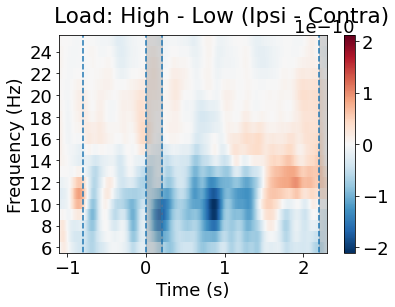

In [25]:
# Calc overall difference between high and low load:
load = 'LoadLow'
side = 'Ipsi'
ga = defaultdict(mne.EvokedArray)
for load in ['LoadHigh', 'LoadLow']:
    tmp = tfr_by_cond[load]
    ga[load] = mne.grand_average(tmp)

diff_ga_data = ga['LoadHigh'].data - ga['LoadLow'].data

info = ga['LoadHigh'].info
diff_ga = mne.time_frequency.AverageTFR(info, diff_ga_data, times, freqs, nave=21)

diff_diff = get_lateralized_power_difference(diff_ga, config.chans_CDA_dict['Contra'], 
                                                      config.chans_CDA_dict['Ipsi'])

fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_diff, picks=config.chans_CDA_dict['Contra'], 
            tmin=-1.1, tmax=2.3, title="Load: High - Low (Contra - Ipsi)", cbar=True, 
            vmin=-6e-10, vmax=6e-10)

We run a quick CBP test to check if anything in this plot is significant:

In [205]:
tt = dict()
for load in ['LoadHigh', 'LoadLow']:
    tmp = tfr_by_cond[load]
    tt[load] = [get_lateralized_power_difference(t, config.chans_CDA_dict['Contra'], 
                                                      config.chans_CDA_dict['Ipsi']) for t in tmp]
ddd = np.array([(h.data - l.data).mean(0) for h,l in zip(tt['LoadHigh'], tt['LoadLow'])])
adjacency = mne.stats.combine_adjacency(*ddd.shape[-2:])
threshold = None  # let MNE calc threshold
n_permutations = 1000  
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_1samp_test(ddd, n_permutations=n_permutations,
                                   threshold=threshold, tail=0,
                                   adjacency=adjacency,
                                   out_type='mask', verbose=True,
                                   n_jobs=-2)
print(f"Test found {np.sum(cluster_p_values < 0.05)} significant clusters (p<.05).")

Using a threshold of 2.085963
stat_fun(H1): min=-3.960081 max=2.930283
Running initial clustering
Found 19 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Test found 0 significant clusters (p<.05).


This does not seem to be the case. Maybe if we average all alpha frequencies?

Now we extract the mean power in the alpha range (8-13Hz) across time and plot it:

stat_fun(H1): min=-4.295639 max=0.736753
Running initial clustering
Found 2 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.


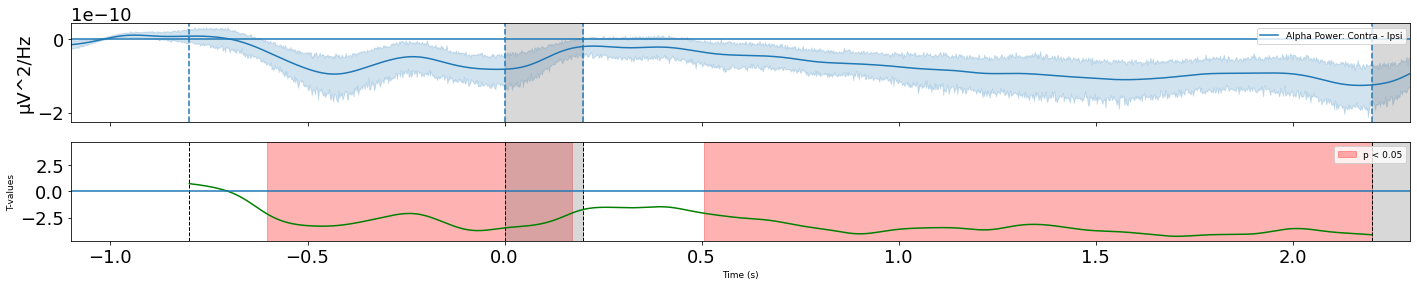

In [45]:
#%% Extract standard alpha (8-13Hz):
frqs_idx = [(8 <= diffs_avgtfr_all[0].freqs) & (diffs_avgtfr_all[0].freqs <= 13)]
diffs_stdalpha_mean = [d.data[:, :, :].mean(axis=(0,1)) for d in diffs_avgtfr_all]

##############################################################################################
# plot it in 2D: 
plt_df = pd.DataFrame(np.array(diffs_stdalpha_mean).swapaxes(1,0), 
                      columns=sub_list_str)
plt_df['time'] = times
plt_df_long = plt_df.melt(id_vars='time', var_name='subID', value_name='pwr')
plt_df_long['hue'] = 'Alpha Power: Contra - Ipsi'

fig, axes = plt.subplots(2, figsize=(24,4), sharex=True)
ax = axes[0]
sns.lineplot(x='time', y='pwr', hue='hue', data=plt_df_long, n_boot=100, ax=ax)
ytick_range = ax.get_ylim()
ax.set(xlim=(-1.1, 2.3), ylim=ytick_range)
ax.set_ylabel('µV^2/Hz')
#ax.set_xlabel('Time (s)')
#ytick_vals = np.arange(*np.round(ytick_range), 2)
#ax.yaxis.set_ticks(ytick_vals)
ax.axvspan(0, 0.2, color='grey', alpha=0.3)
ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
ax.vlines((-0.8, 0, 0.2, 2.2), ymin=ytick_range[0], ymax=ytick_range[1], 
          linestyles='dashed')
ax.hlines(0, xmin=-1.1, xmax=2.3)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc=1, prop={'size': 9})
ax.xaxis.label.set_visible(False)

#%% run CBP test on classical alpha data (sub x times):
# crop to time of interest: 
mask_time = [(times >= -0.8) & (times <= 2.2)]
data = np.array(diffs_stdalpha_mean)[:, mask_time[0]]
T_obs, clusters, c_pvals = run_cbp_test(data, 
                                        p_initial=0.05)


##############################################################################################
# add it to figure:
ax = axes[1]
plot_cbp_result(ax, T_obs, clusters, c_pvals, 0.05, 
                         cbp_times=times[mask_time[0]], 
                         times_full=np.arange(-1.1, 2.3, 0.002))

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', part_epo)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'classAlpha_Difference.png')
fig.savefig(fname, bbox_inches="tight")

We write out CSV files with the mean lateralized alpha power per trial so we can read it into R and run our stats there:

In [70]:

#%% Export single trial data about lateral. difference in alpha power 
# for the CDA ROI during the sign cluster:

# For the retention intervall, we look at the 2nd cluster.
cluster_dict = {'name': 'retention', 
                't_start': times[mask_time[0]][clusters[1]][0], 
                't_stop': times[mask_time[0]][clusters[1]][-1]}

mean_pwrdiff_list = list()
for sub in sub_list:
    subID = 'VME_S%02d' % sub
    mean_pwrdiff_df = get_mean_pwrdiff_per_trial(subID, freqs_to_avg=np.arange(8,13), 
                                                 t_start= cluster_dict['t_start'], 
                                                 t_stop= cluster_dict['t_stop'])
    # Write subject data to disk:
    fpath = op.join(config.paths["05_tfrs-summaries"], pwr_style, cluster_dict['name'])
    helpers.chkmk_dir(fpath)
    fname = op.join(fpath, f'{subID}-mean_pwrdiff_{cluster_dict["name"]}.csv')
    mean_pwrdiff_df.to_csv(fname, index=False)
    mean_pwrdiff_list.append(mean_pwrdiff_df)

mean_pwrdiff_all_df = pd.concat(mean_pwrdiff_list)
# Write subject data to disk:
fpath = op.join(config.paths["05_tfrs-summaries"], pwr_style, cluster_dict['name'], 
                'global_summary')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, f'allsubjects-mean_pwrdiff_{cluster_dict["name"]}.csv')
mean_pwrdiff_all_df.to_csv(fname, index=False)


Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S01-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
659 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  2   5   7  12  14  25  38  42  46  64  73  77  94  96 100 108 112 116
 118 133 149 151 159 172 183 187 208 216 228 234 251 254 259 262 273 280
 292 296 301 304 305 312 318 330 333 342 344 350 364 377 387 389 395 396
 398 420 425 430 436 446 450 458 459 476 500 503 506 510 518 522 538 541
 552 560 566 575 580 592 597 604 605 632 633 639 640 648 671 675 676 682
 685 693 698 705 710 717]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    1.0s remaining:    2.4s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.1s finished


0       2
1       5
2       7
3      12
4      14
     ... 
91    693
92    698
93    705
94    710
95    717
Name: epoch, Length: 96, dtype: int64
[  0   1   6  24  33  34  44  50  51  54  55  56  72  83  88 105 106 114
 117 120 122 125 136 145 150 165 176 177 182 189 192 197 198 212 214 219
 223 226 227 229 232 235 238 241 261 270 279 300 308 311 315 320 328 335
 336 347 352 355 357 367 368 371 372 373 376 393 405 406 411 422 431 440
 441 443 445 455 462 463 468 477 490 502 512 515 520 535 542 545 548 554
 558 561 563 568 584 585 595 596 612 616 621 627 635 636 651 654 659 660
 661 666 688 689 690 701 707 714]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.2s finished


0        0
1        1
2        6
3       24
4       33
      ... 
111    689
112    690
113    701
114    707
115    714
Name: epoch, Length: 116, dtype: int64
[ 11  15  17  22  23  29  43  52  63  65  66  67  74  75  78  89 103 111
 121 124 129 137 141 142 148 152 156 157 163 166 169 175 195 196 200 205
 218 230 236 243 249 255 257 264 267 283 286 287 294 302 306 319 324 327
 331 332 340 343 348 353 360 362 380 383 385 386 390 402 404 412 429 433
 437 439 444 467 471 480 493 497 498 501 511 513 519 521 539 540 544 557
 562 569 571 576 589 593 601 602 610 615 617 618 619 638 650 653 655 665
 670 673 680 694 696 700 719]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    1.0s finished


0       11
1       15
2       17
3       22
4       23
      ... 
110    680
111    694
112    696
113    700
114    719
Name: epoch, Length: 115, dtype: int64
[  4   9  10  18  20  30  32  39  41  47  48  62  81  82  87  93  95  97
  98  99 101 126 131 144 147 153 158 164 178 179 180 186 193 204 217 233
 240 246 258 265 266 268 272 276 284 291 295 297 303 307 314 317 321 338
 341 346 349 369 374 382 392 394 397 399 410 423 435 461 465 466 483 484
 485 488 492 496 499 508 514 523 525 531 532 536 546 564 570 577 578 581
 586 598 603 614 624 637 645 646 652 656 658 668 679 686 699 708 713 715
 716]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        4
1        9
2       10
3       18
4       20
      ... 
104    699
105    708
106    713
107    715
108    716
Name: epoch, Length: 109, dtype: int64
[  8  16  21  27  35  40  45  58  59  61  70  71  76  84  86  90  92 104
 115 119 128 138 143 160 161 167 173 181 184 191 194 201 206 215 221 222
 225 242 244 250 252 256 269 274 277 285 289 290 293 298 309 310 323 329
 345 358 361 365 370 375 379 381 384 388 391 415 427 438 454 464 469 470
 472 473 474 487 489 495 504 505 507 527 529 543 547 550 551 556 559 582
 587 599 600 606 613 620 641 643 644 649 674 677 683 692 695 697 711]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        8
1       16
2       21
3       27
4       35
      ... 
102    683
103    692
104    695
105    697
106    711
Name: epoch, Length: 107, dtype: int64
[  3  13  19  26  28  31  36  37  49  53  57  60  79  80  85 102 107 110
 123 127 130 132 135 139 146 155 170 171 174 188 190 199 207 209 211 231
 237 245 248 253 260 263 271 275 278 281 282 288 299 313 325 326 334 337
 339 351 354 356 359 366 403 408 409 413 414 418 419 421 426 432 434 442
 447 448 449 451 452 453 457 479 481 509 516 524 526 530 533 534 537 549
 553 573 588 590 594 607 608 611 622 626 628 631 634 647 657 662 663 667
 669 672 684 703 706 709 712 718]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        3
1       13
2       19
3       26
4       28
      ... 
111    703
112    706
113    709
114    712
115    718
Name: epoch, Length: 116, dtype: int64
creating dir: /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/summaries/induced/retention
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S02-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
713 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  9  18  22  27  44  46  47  52  58  59  60  66  72  85  86  92  99 101
 110 133 135 139 140 143 144 146 147 153 155 156 168 172 183 195 196 200
 218 219 220 224 232 236 240 254 261 272 27

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        9
1       18
2       22
3       27
4       44
      ... 
114    699
115    702
116    714
117    715
118    718
Name: epoch, Length: 119, dtype: int64
[  4  11  13  14  16  21  28  32  45  49  51  69  73  79  84  89  90  98
 100 108 122 126 138 164 165 170 173 174 175 186 192 194 206 211 215 216
 221 225 227 229 233 255 258 268 271 285 287 290 300 309 313 321 325 334
 335 342 345 350 352 360 377 380 387 399 402 403 407 410 416 421 423 434
 439 446 456 465 468 472 475 487 493 499 500 504 523 525 526 531 539 543
 551 553 558 563 571 587 592 593 599 603 604 606 625 628 632 633 636 661
 664 667 673 677 680 689 698 704 712 716 717]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        4
1       11
2       13
3       14
4       16
      ... 
114    698
115    704
116    712
117    716
118    717
Name: epoch, Length: 119, dtype: int64
[  6   7  12  15  23  24  25  26  29  35  62  63  74  77  83  91 102 107
 112 117 121 124 132 137 150 152 158 169 177 187 190 193 198 208 212 213
 226 230 239 253 256 257 260 262 269 275 278 284 292 293 294 306 311 316
 317 318 320 336 343 348 361 366 371 375 383 388 390 404 405 408 409 412
 433 441 442 444 453 455 460 461 470 474 477 496 505 506 510 513 518 520
 529 538 548 549 552 564 589 591 595 596 601 607 613 622 624 626 639 644
 648 652 656 658 668 669 672 683 697 703 705 711]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        6
1        7
2       12
3       15
4       23
      ... 
115    683
116    697
117    703
118    705
119    711
Name: epoch, Length: 120, dtype: int64
[  0   5  10  30  31  36  37  43  54  56  57  67  80  87  88  93 106 113
 115 118 123 129 136 149 157 159 160 163 166 178 181 185 199 203 209 217
 222 234 235 237 238 246 248 267 277 283 286 288 291 302 304 307 315 333
 346 349 351 354 355 362 364 370 384 386 389 396 398 401 419 427 431 447
 450 451 452 469 473 476 478 481 494 497 508 509 515 521 522 532 540 542
 554 556 562 566 576 582 590 605 609 610 614 616 617 621 642 646 650 655
 666 676 679 681 687 690 696 707 710]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1        5
2       10
3       30
4       31
      ... 
112    687
113    690
114    696
115    707
116    710
Name: epoch, Length: 117, dtype: int64
[  3  17  19  20  34  38  39  53  55  61  70  76  95  96 103 114 116 119
 125 127 128 131 134 145 151 162 171 176 179 182 188 201 204 205 207 228
 231 247 250 252 263 266 270 273 274 279 281 295 296 297 308 312 314 326
 327 328 331 340 353 365 367 378 391 392 394 397 411 415 422 428 430 432
 437 440 445 449 457 462 463 466 483 489 491 511 519 530 537 541 546 547
 557 559 570 572 574 579 583 588 600 602 615 618 619 623 627 629 637 651
 654 662 674 678 688 693 694 700 706 713 719]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        3
1       17
2       19
3       20
4       34
      ... 
114    694
115    700
116    706
117    713
118    719
Name: epoch, Length: 119, dtype: int64
[  1   2   8  40  41  42  48  50  64  65  68  71  75  78  81  82  94  97
 104 105 109 120 130 142 148 154 161 167 180 184 189 191 197 202 210 214
 223 241 242 243 244 245 249 251 259 264 265 280 289 298 303 305 319 322
 323 329 330 337 341 357 363 368 369 372 373 379 382 393 395 420 425 429
 436 438 448 454 458 459 471 479 480 482 488 492 514 516 524 528 550 555
 560 561 567 568 573 581 584 585 598 611 612 620 638 640 641 645 647 663
 665 670 682 684 685 686 691 692 695 701 708]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        1
1        2
2        8
3       40
4       41
      ... 
114    691
115    692
116    695
117    701
118    708
Name: epoch, Length: 119, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S03-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
623 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  4   8  14  16  18  19  36  37  46  60  64  72  81  86  88  98 114 115
 125 134 135 142 147 149 150 162 164 168 169 170 172 178 186 234 236 257
 258 262 265 268 271 280 282 284 285 290 297 302 305 313 314 321 325 334
 338 353 361 372 378 

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        4
1        8
2       14
3       16
4       18
      ... 
101    675
102    681
103    689
104    706
105    714
Name: epoch, Length: 106, dtype: int64
[ 17  20  26  35  38  43  44  53  58  65  76  79  89  92  94  97 100 105
 116 128 138 143 160 171 179 185 192 195 196 201 206 213 216 221 222 228
 239 243 247 249 267 272 276 289 293 299 306 307 317 322 330 332 335 342
 367 368 369 373 380 385 393 394 433 436 454 461 471 477 481 489 493 495
 503 508 513 516 518 530 532 542 552 557 584 600 601 618 621 626 627 628
 634 639 646 652 657 658 660 663 668 670 695 718]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       17
1       20
2       26
3       35
4       38
      ... 
97     663
98     668
99     670
100    695
101    718
Name: epoch, Length: 102, dtype: int64
[  0   7  13  15  40  41  45  51  56  61  70  78  80  84  85  91 102 110
 121 122 123 139 141 146 154 156 177 184 194 198 199 207 211 215 229 233
 238 241 242 250 270 274 278 279 281 286 288 291 296 300 315 323 326 343
 352 356 358 359 377 382 386 398 405 410 414 415 418 424 425 438 441 445
 450 459 468 472 473 486 497 509 510 511 515 526 533 534 538 540 562 569
 576 592 593 597 603 615 617 624 642 650 654 672 677 679 680 685 686 688
 690 696 704]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1        7
2       13
3       15
4       40
      ... 
106    686
107    688
108    690
109    696
110    704
Name: epoch, Length: 111, dtype: int64
[  9  10  11  12  23  29  42  50  52  57  62  67  93  99 101 107 109 111
 119 120 131 136 137 140 148 153 173 175 176 187 200 202 204 217 220 224
 226 244 252 253 256 283 298 304 318 327 331 333 345 346 347 348 360 374
 375 379 389 392 411 413 427 428 431 442 446 452 455 458 463 466 467 498
 500 501 512 529 536 543 545 547 549 561 578 588 602 604 609 619 625 635
 641 644 647 684 687 693 700 702 707 710]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       9
1      10
2      11
3      12
4      23
     ... 
95    693
96    700
97    702
98    707
99    710
Name: epoch, Length: 100, dtype: int64
[  1   2   3   5  21  25  28  30  32  34  69  75  87  90 104 106 108 112
 117 124 132 133 158 161 163 167 174 183 191 193 203 205 212 218 231 237
 240 246 254 259 260 264 275 277 295 310 311 316 339 340 341 350 355 366
 383 384 400 404 406 408 416 430 435 447 449 451 462 465 478 491 525 528
 531 546 548 556 559 568 571 575 591 596 598 608 614 630 637 643 656 661
 667 683 691 703 716 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       1
1       2
2       3
3       5
4      21
     ... 
91    683
92    691
93    703
94    716
95    719
Name: epoch, Length: 96, dtype: int64
[  6  27  31  33  47  48  54  55  59  63  66  74  77  82  95  96 113 118
 126 127 130 151 152 155 159 166 181 182 188 197 209 214 223 225 227 232
 235 251 255 261 263 266 301 303 309 312 320 337 344 349 351 354 357 362
 363 370 376 388 390 391 399 407 412 420 423 439 448 464 469 474 475 476
 482 490 494 499 502 506 523 524 535 539 551 554 560 563 567 572 579 580
 585 589 595 607 613 616 623 649 651 671 692 694 699 701 708 709 712 713]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        6
1       27
2       31
3       33
4       47
      ... 
103    701
104    708
105    709
106    712
107    713
Name: epoch, Length: 108, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S04-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
609 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[ 10  16  18  36  46  49  61  67  75  78  80  82  87  92  99 101 103 115
 129 132 146 155 156 157 167 173 190 193 211 223 239 241 244 250 258 264
 277 301 304 310 313 323 330 331 344 355 356 360 361 363 365 389 393 400
 409 419 429 443 451 456 465 469 479 488 489 497 501 510 511 514 526 528
 530 531 53

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       10
1       16
2       18
3       36
4       46
      ... 
96     697
97     704
98     710
99     714
100    719
Name: epoch, Length: 101, dtype: int64
[  7  12  13  59  60  63  65  68  72  76  89 108 117 119 121 126 127 137
 142 148 150 171 174 176 181 188 191 192 196 203 217 224 227 228 235 236
 237 255 268 271 291 305 306 319 328 332 335 339 359 383 385 388 396 407
 408 411 422 431 459 468 470 484 486 490 492 494 496 527 529 537 545 549
 551 560 567 569 572 578 581 584 586 588 603 617 629 635 637 644 649 650
 651 654 668 670 674 675 679 681 709]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       7
1      12
2      13
3      59
4      60
     ... 
94    674
95    675
96    679
97    681
98    709
Name: epoch, Length: 99, dtype: int64
[  1   3  15  17  41  45  50  51  81  83  93  94  98 102 104 113 122 125
 136 138 151 163 164 179 180 189 204 209 210 213 215 218 253 256 260 267
 273 274 281 283 293 302 307 324 334 342 351 367 368 391 394 395 397 402
 404 418 430 439 446 462 467 472 480 481 491 495 509 515 520 548 553 565
 571 575 582 593 594 612 614 619 622 631 632 641 643 645 656 660 661 663
 666 680 685 689 701 703 715]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       1
1       3
2      15
3      17
4      41
     ... 
92    685
93    689
94    701
95    703
96    715
Name: epoch, Length: 97, dtype: int64
[  0   5  11  47  52  54  58  69  77  86  88  90  95  96  97 100 111 120
 124 140 144 147 152 159 161 162 169 175 198 200 207 220 229 230 238 245
 254 270 278 279 285 286 292 294 300 303 317 325 337 338 343 347 353 369
 371 376 379 381 392 398 399 405 416 424 427 441 455 460 461 463 464 478
 487 502 518 521 522 536 538 546 547 550 554 557 562 576 577 579 583 599
 600 623 625 626 630 636 639 671 677 683 688 693 705 706 708]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        0
1        5
2       11
3       47
4       52
      ... 
100    688
101    693
102    705
103    706
104    708
Name: epoch, Length: 105, dtype: int64
[  2   4   6  20  43  57  62  74 105 106 107 109 112 114 118 128 131 133
 141 160 165 168 177 186 197 199 201 205 214 221 231 242 243 247 248 263
 269 287 314 315 316 320 329 336 340 345 346 352 358 362 370 373 375 378
 387 390 403 414 415 425 473 477 483 485 493 498 506 507 512 513 523 534
 535 544 556 558 563 595 596 597 602 607 609 616 618 621 627 634 647 655
 659 669 682 696 699 700 702 707 712 713 717]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1        4
2        6
3       20
4       43
      ... 
96     702
97     707
98     712
99     713
100    717
Name: epoch, Length: 101, dtype: int64
[ 44  48  53  55  56  64  66  70  71  73  79  84  91 110 116 123 130 134
 135 139 143 145 158 172 178 182 183 184 185 187 208 212 222 246 249 251
 252 257 272 275 276 282 284 288 297 312 322 327 341 348 349 350 354 357
 366 372 374 377 382 406 417 423 426 428 432 440 445 454 458 466 471 474
 475 476 503 508 517 539 540 542 552 555 564 566 568 570 574 580 585 589
 591 620 628 633 640 642 648 657 658 665 673 687 690 711 716 718]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       44
1       48
2       53
3       55
4       56
      ... 
101    687
102    690
103    711
104    716
105    718
Name: epoch, Length: 106, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S05-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
704 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  3  22  26  31  36  38  39  43  49  58  61  70  79  85  89  97 100 107
 108 116 127 128 135 137 144 146 164 165 178 183 193 194 196 205 206 210
 220 224 230 237 248 250 254 259 265 267 282 283 288 289 299 316 322 327
 335 338 344 346 353 354 360 367 380 395 397 398 399 411 421 425 430 431
 433 439 44

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        3
1       22
2       26
3       31
4       36
      ... 
112    689
113    690
114    699
115    714
116    715
Name: epoch, Length: 117, dtype: int64
[ 10  14  18  19  23  24  25  34  40  55  67  71  72  74  90  92 102 103
 109 115 117 126 130 141 149 160 163 167 172 176 189 199 201 202 204 207
 227 228 233 240 246 251 256 266 271 272 273 279 304 305 307 308 311 313
 319 324 333 347 351 359 365 370 373 379 383 389 390 409 414 418 422 423
 436 440 450 465 468 477 481 486 491 495 496 498 506 523 524 532 545 549
 551 553 556 561 563 567 576 577 583 585 593 595 596 605 607 610 632 633
 649 652 656 662 674 678 680 700 702 705 718]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       10
1       14
2       18
3       19
4       23
      ... 
114    680
115    700
116    702
117    705
118    718
Name: epoch, Length: 119, dtype: int64
[  6   8   9  11  17  21  30  35  42  44  54  65  73  81  84  91  98  99
 101 118 124 133 138 142 152 157 158 161 170 175 177 186 188 208 209 213
 218 221 222 229 239 252 253 263 275 277 281 287 290 294 298 321 329 330
 336 341 343 348 350 355 361 366 375 376 381 393 394 405 407 412 416 427
 435 437 442 444 447 478 482 483 484 487 488 493 504 505 511 513 514 519
 528 552 554 559 571 573 578 589 594 597 617 620 621 627 635 638 643 646
 648 657 659 665 670 679 681 683 688 691 701 711]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        6
1        8
2        9
3       11
4       17
      ... 
115    683
116    688
117    691
118    701
119    711
Name: epoch, Length: 120, dtype: int64
[ 13  16  20  32  37  45  46  62  63  64  69  76  80  83  93 106 112 113
 114 122 131 136 140 147 151 154 171 173 185 187 190 191 198 200 215 216
 219 231 238 245 255 257 258 260 268 280 295 301 309 314 315 318 332 342
 352 356 357 363 378 386 387 388 392 401 404 417 419 426 428 432 438 445
 457 459 460 470 471 499 501 502 520 525 529 533 535 539 540 542 558 560
 568 575 580 586 587 591 600 604 606 609 619 637 641 661 668 673 675 687
 703 704 712 713 716]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       13
1       16
2       20
3       32
4       37
      ... 
108    703
109    704
110    712
111    713
112    716
Name: epoch, Length: 113, dtype: int64
[  4   7  15  33  50  52  53  56  57  59  60  66  75  82  86  88  95 110
 120 121 125 129 132 143 150 153 159 162 166 169 174 180 192 203 212 241
 242 243 244 247 249 262 269 270 276 285 291 292 293 296 300 302 303 317
 323 334 339 345 372 377 385 396 400 406 408 410 413 420 424 429 434 443
 446 455 461 463 464 469 472 475 480 494 517 527 530 536 537 541 546 547
 562 566 570 574 581 582 592 601 613 614 624 631 639 642 644 651 655 663
 666 672 692 695 698 706 707 708]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        4
1        7
2       15
3       33
4       50
      ... 
111    695
112    698
113    706
114    707
115    708
Name: epoch, Length: 116, dtype: int64
[  0   1   2   5  12  27  28  29  41  47  48  51  77  78  87  94  96 104
 105 111 119 123 134 139 145 148 155 156 168 179 182 184 195 197 211 214
 217 223 225 226 232 234 235 236 261 274 278 286 297 306 312 320 325 326
 328 331 337 340 349 358 362 364 368 369 371 374 382 384 391 402 403 415
 448 451 452 453 458 466 467 474 479 485 489 490 508 509 515 516 518 521
 522 526 543 557 564 572 588 590 598 599 603 608 612 615 616 626 634 650
 653 654 658 667 677 684 685 686 693 696 719]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1        1
2        2
3        5
4       12
      ... 
114    685
115    686
116    693
117    696
118    719
Name: epoch, Length: 119, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S06-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
711 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  3   4   5   7  13  18  31  39  40  46  53  59  74  82  84  86  88  90
 105 107 111 121 122 131 163 164 165 170 180 182 186 198 205 210 212 223
 233 242 255 259 260 262 268 274 276 282 286 291 293 297 302 303 306 315
 316 318 329 354 358 

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        3
1        4
2        5
3        7
4       13
      ... 
113    690
114    699
115    701
116    712
117    718
Name: epoch, Length: 118, dtype: int64
[  1  10  14  22  33  42  45  52  58  60  71  75  83  87  92  98  99 102
 114 130 133 135 141 154 156 157 167 192 195 196 199 201 203 204 209 221
 227 231 243 246 252 253 270 278 279 280 283 298 300 314 319 321 337 338
 343 344 352 353 355 362 367 378 387 389 397 410 413 414 415 420 424 433
 441 453 458 462 463 467 476 485 496 501 508 518 519 525 529 539 545 550
 558 567 570 575 582 586 587 590 595 598 607 612 622 628 636 637 650 659
 665 666 669 672 675 680 686 692 693 714]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        1
1       10
2       14
3       22
4       33
      ... 
113    680
114    686
115    692
116    693
117    714
Name: epoch, Length: 118, dtype: int64
[  6  12  19  23  26  28  30  38  41  43  51  63  81  85  93 104 106 108
 112 113 117 119 125 128 160 166 168 172 178 181 188 189 197 200 207 214
 216 217 225 229 244 245 249 250 264 271 273 281 301 304 305 327 333 340
 347 348 349 350 357 361 365 366 371 372 373 376 390 417 419 425 430 440
 446 448 456 459 461 466 468 469 475 492 498 513 514 515 526 527 528 532
 540 561 564 568 571 576 580 583 588 599 601 603 617 624 631 635 639 651
 653 656 660 662 674 679 698 700 703 707 713]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        6
1       12
2       19
3       23
4       26
      ... 
114    698
115    700
116    703
117    707
118    713
Name: epoch, Length: 119, dtype: int64
[ 20  24  25  27  34  37  44  61  65  66  68  69  72  73  78  80 100 103
 109 115 116 123 124 145 146 149 150 151 152 169 185 190 208 213 215 218
 226 236 239 241 248 254 258 263 267 275 284 290 292 294 296 307 308 317
 326 331 334 335 359 369 370 383 388 391 393 405 409 418 423 438 445 452
 454 465 470 472 481 487 488 489 490 504 505 510 512 534 535 547 549 552
 554 559 566 591 597 600 604 606 608 609 618 640 643 644 645 648 652 658
 667 677 681 683 688 696 704 706 708]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0       20
1       24
2       25
3       27
4       34
      ... 
112    688
113    696
114    704
115    706
116    708
Name: epoch, Length: 117, dtype: int64
[  2   8   9  11  16  17  29  35  56  62  64  67  77  89  91  95 110 118
 126 127 134 136 139 140 144 148 155 159 171 173 175 177 187 191 193 202
 230 232 234 235 237 238 240 256 261 269 272 277 288 289 299 310 311 320
 324 330 332 339 346 356 364 379 386 392 394 395 403 407 408 426 428 431
 434 435 447 449 455 464 474 479 480 494 499 506 521 524 548 555 556 557
 560 563 565 569 573 581 592 593 596 605 611 619 627 634 642 646 647 676
 678 689 694 697 702 709 710 711 715 716 717]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        2
1        8
2        9
3       11
4       16
      ... 
114    710
115    711
116    715
117    716
118    717
Name: epoch, Length: 119, dtype: int64
[  0  15  21  32  36  47  48  49  50  54  57  70  76  79  94  96 101 120
 129 132 137 138 142 143 147 153 158 161 162 174 176 179 183 194 206 211
 219 220 222 224 228 247 251 257 265 266 285 287 295 309 312 313 322 323
 328 336 341 342 345 351 368 374 375 385 399 400 401 404 411 412 422 427
 432 450 451 457 460 473 477 478 482 484 486 500 509 516 517 520 522 523
 543 544 546 551 553 574 577 578 585 589 610 613 615 616 625 632 633 638
 654 664 668 670 671 673 684 687 691 695 705 719]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1       15
2       21
3       32
4       36
      ... 
115    687
116    691
117    695
118    705
119    719
Name: epoch, Length: 120, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S07-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
704 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[ 20  29  34  45  49  51  52  56  57  67  70  73  75  80  93  94 100 107
 113 119 131 142 145 166 167 193 200 204 206 208 210 211 215 224 225 232
 244 250 255 256 270 277 285 289 290 296 300 301 303 326 343 345 355 360
 366 375 379 386 391 

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       20
1       29
2       34
3       45
4       49
      ... 
108    686
109    688
110    692
111    708
112    717
Name: epoch, Length: 113, dtype: int64
[  3   8  18  26  28  33  36  37  40  46  48  61  72  92  98 116 120 126
 128 129 130 137 146 150 156 159 160 161 183 184 186 196 203 213 220 227
 234 245 246 254 259 265 272 282 286 287 288 292 310 316 317 328 338 339
 349 350 356 358 362 365 388 389 396 402 408 412 422 425 426 444 446 458
 461 463 473 474 478 480 482 488 491 506 510 512 516 518 524 532 549 551
 553 564 570 576 578 584 590 593 595 610 614 622 624 626 639 651 658 659
 660 675 677 682 693 698 701 705 713]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        3
1        8
2       18
3       26
4       28
      ... 
112    693
113    698
114    701
115    705
116    713
Name: epoch, Length: 117, dtype: int64
[ 10  14  17  22  23  27  30  31  39  44  54  66  78  82  86  88  89  95
 117 118 132 133 135 136 155 158 162 169 170 172 178 182 195 198 202 214
 217 218 240 241 243 249 257 263 266 271 273 276 307 309 313 319 321 323
 329 330 335 340 341 351 363 364 367 368 372 378 385 394 406 416 418 424
 445 450 454 465 475 476 483 484 493 500 503 509 513 514 525 535 536 543
 552 555 563 572 575 582 583 585 586 587 592 606 617 623 625 627 640 649
 674 676 681 687 689 695 703 706 707 715 718]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0       10
1       14
2       17
3       22
4       23
      ... 
114    703
115    706
116    707
117    715
118    718
Name: epoch, Length: 119, dtype: int64
[  2   4  11  19  21  38  41  47  59  62  68  71  74  87 101 103 109 112
 121 122 124 127 138 141 144 148 151 152 157 164 174 176 181 185 190 205
 221 223 226 235 236 247 248 261 264 269 275 278 294 304 312 318 320 332
 336 346 347 348 352 359 370 374 381 384 390 392 403 411 413 415 420 428
 437 439 448 455 457 462 466 472 485 487 489 499 507 520 527 533 540 542
 548 550 556 566 568 569 581 588 589 591 598 603 604 608 612 615 629 667
 668 673 685 690 694 696 699 700 702 712 716]
Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
0        2
1        4
2       11
3       19
4       21
      ... 
114    699
115    700
116    702
117    712
118    716
Name: epoch, Length: 119, dtype: int64
[  0   5   6  12  16  25  43  53  55  58  65  77  81  83  96  97 104 110
 111 114 115 139 140 153 168 171 179 180 191 192 194 197 201 212 222 229
 230 231 233 238 253 258 267 274 281 284 298 302 308 314 315 322 325 331
 333 334 337 342 361 369 371 380 383 395 405 407 409 417 427 433 434 438
 442 453 456 460 467 468 492 494 495 519 523 530 534 537 546 557 559 561
 565 567 573 579 580 599 601 621 630 631 633 634 635 646 648 652 654 656
 657 661 664 665 669 697 710 714]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        0
1        5
2        6
3       12
4       16
      ... 
111    665
112    669
113    697
114    710
115    714
Name: epoch, Length: 116, dtype: int64
[  1   7  13  15  24  32  35  42  50  60  63  64  76  79  90  91  99 102
 106 108 123 125 134 143 147 149 154 163 165 173 175 177 187 189 199 209
 216 219 237 239 242 251 252 260 268 279 280 283 291 293 295 297 299 306
 311 324 327 344 354 357 373 376 377 382 393 398 399 400 401 421 429 430
 441 451 459 464 470 477 486 490 496 497 498 502 504 508 511 515 528 529
 531 539 541 545 547 558 577 594 596 602 613 628 632 637 641 642 643 644
 653 655 666 670 672 679 684 691 704 709 711 719]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        1
1        7
2       13
3       15
4       24
      ... 
115    691
116    704
117    709
118    711
119    719
Name: epoch, Length: 120, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S08-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
617 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  1  13  20  21  23  26  30  38  53  56  57  61  78  85  89  94  98 101
 108 113 138 144 149 154 158 165 170 178 182 208 214 217 224 226 229 231
 244 250 257 262 273 291 292 294 308 319 323 325 328 341 348 356 363 377
 379 383 385 397 400 

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        1
1       13
2       20
3       21
4       23
      ... 
102    657
103    668
104    684
105    691
106    711
Name: epoch, Length: 107, dtype: int64
[  7  11  34  37  47  48  51  54  59  66  67  70  77  99 118 119 121 124
 136 137 155 156 172 173 183 188 194 196 204 206 218 238 243 247 260 261
 263 279 283 284 293 296 304 305 317 324 326 333 338 347 352 354 369 370
 372 376 386 390 392 412 414 421 427 434 456 459 483 489 492 496 499 500
 502 514 516 521 522 523 531 547 549 555 563 569 581 591 593 612 622 623
 625 626 630 637 644 655 663 670 679 682 690 696 698 703]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        7
1       11
2       34
3       37
4       47
      ... 
99     682
100    690
101    696
102    698
103    703
Name: epoch, Length: 104, dtype: int64
[  4   8  17  22  24  33  41  42  63  69  82  90  96 103 105 114 115 122
 127 147 150 152 157 167 174 184 186 195 198 212 220 223 228 246 259 266
 270 276 277 282 285 297 311 315 330 331 332 339 342 343 349 350 359 365
 374 387 389 393 399 401 405 407 423 433 435 440 451 453 458 467 468 474
 482 484 495 505 519 520 525 534 541 544 545 562 580 587 590 606 608 610
 620 628 636 642 650 652 658 681 683 686 689 699 710 714]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        4
1        8
2       17
3       22
4       24
      ... 
99     686
100    689
101    699
102    710
103    714
Name: epoch, Length: 104, dtype: int64
[  0   5  12  16  18  28  29  31  35  55  72  76  84  86  87  92  95 107
 116 135 145 151 168 179 180 192 197 199 216 232 233 234 237 251 265 269
 280 287 290 295 301 309 310 321 329 337 340 346 364 367 368 371 373 375
 378 398 402 403 404 432 439 442 443 461 471 491 493 494 498 501 510 513
 517 528 550 558 570 572 573 574 576 577 578 596 597 601 609 624 629 635
 638 646 662 664 665 672 674 677 680 692 695 701]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        0
1        5
2       12
3       16
4       18
      ... 
97     677
98     680
99     692
100    695
101    701
Name: epoch, Length: 102, dtype: int64
[  2   3   6  14  15  25  32  39  49  58  60  74  91  97 102 120 123 130
 132 133 142 146 148 153 164 177 185 201 207 211 221 222 225 235 248 255
 264 271 274 281 298 299 302 303 314 318 320 327 334 336 353 366 380 381
 382 388 394 395 411 424 428 436 441 457 464 466 469 477 481 485 504 524
 532 533 539 552 559 564 565 568 571 584 585 594 600 611 615 617 621 634
 639 643 647 666 669 671 675 676 678 685 694 712]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1        3
2        6
3       14
4       15
      ... 
97     676
98     678
99     685
100    694
101    712
Name: epoch, Length: 102, dtype: int64
[  9  10  27  36  43  44  45  50  65  71  73  75  83  88 104 106 111 112
 117 131 143 159 162 169 171 181 187 200 203 205 210 215 227 239 241 242
 245 249 268 272 275 278 286 288 289 300 306 307 313 316 322 345 355 360
 384 391 396 406 408 415 416 419 431 438 444 446 447 452 472 473 478 479
 497 503 506 512 515 530 538 543 554 556 560 575 579 588 592 595 599 614
 619 631 653 654 659 661 667 702]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       9
1      10
2      27
3      36
4      43
     ... 
93    654
94    659
95    661
96    667
97    702
Name: epoch, Length: 98, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S09-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
568 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  0   6  11  26  33  38  41  50  51  57  58  81  86 102 104 108 112 114
 141 147 148 157 164 175 180 195 196 197 208 224 226 239 240 254 258 261
 269 273 275 277 283 303 306 307 313 322 328 339 342 347 360 363 372 373
 377 387 397 399 435 439 463 464 474 477 478 484 500 506 512 529 533 536
 541 545 547 550 556 56

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       0
1       6
2      11
3      26
4      33
     ... 
87    677
88    679
89    693
90    698
91    714
Name: epoch, Length: 92, dtype: int64
[  5  10  12  13  17  23  29  30  32  46  56  67  79  97 100 103 106 110
 115 118 123 139 146 152 156 160 162 168 171 178 186 191 192 219 221 233
 245 246 253 260 267 279 281 304 305 309 311 321 334 353 366 370 410 411
 417 431 432 434 444 449 469 486 496 501 503 509 511 515 526 530 538 563
 568 574 580 585 591 593 600 606 617 646 657 665 681 684 687 699 708 709]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       5
1      10
2      12
3      13
4      17
     ... 
85    684
86    687
87    699
88    708
89    709
Name: epoch, Length: 90, dtype: int64
[  3   9  18  19  20  21  24  31  59  70  87  88 101 116 119 122 127 138
 142 145 149 163 166 169 177 185 198 202 203 215 223 228 231 238 241 255
 257 259 263 268 270 280 290 291 295 317 319 338 341 343 348 354 356 365
 369 383 390 392 401 406 409 415 436 445 447 450 453 456 457 460 473 482
 488 502 505 508 513 525 531 540 542 555 558 567 579 596 607 621 623 626
 652 682 683 685 697 700 707]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       3
1       9
2      18
3      19
4      20
     ... 
92    683
93    685
94    697
95    700
96    707
Name: epoch, Length: 97, dtype: int64
[ 14  25  27  35  36  44  49  52  53  54  71  84  85  98 109 125 126 130
 133 134 135 136 154 158 167 172 179 188 193 204 205 214 217 218 220 229
 232 234 235 251 252 256 282 288 298 299 300 312 336 345 346 358 364 367
 371 374 376 382 386 393 394 412 422 433 437 438 454 465 466 471 479 490
 491 516 519 520 527 539 544 549 551 564 577 581 610 613 635 637 643 648
 651 655 669 689]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0      14
1      25
2      27
3      35
4      36
     ... 
89    648
90    651
91    655
92    669
93    689
Name: epoch, Length: 94, dtype: int64
[  1   7  15  16  22  40  42  55  61  65  72  74  93  95 113 121 128 129
 131 143 150 151 155 159 161 183 187 190 201 216 222 227 243 249 250 265
 266 272 274 286 297 302 308 323 327 340 349 355 385 388 395 426 430 440
 441 455 459 461 468 476 480 487 489 492 499 517 528 535 548 552 559 566
 572 586 587 588 602 604 608 618 627 638 642 649 672 675 676 688 692 702]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       1
1       7
2      15
3      16
4      22
     ... 
85    675
86    676
87    688
88    692
89    702
Name: epoch, Length: 90, dtype: int64
[  2   4   8  28  34  37  39  45  47  66  68  69  73  83  96 105 117 120
 124 132 137 140 153 165 170 174 181 184 199 209 210 211 212 225 230 236
 237 242 244 262 271 276 289 294 296 310 318 320 326 344 351 357 359 361
 368 375 384 396 398 403 414 421 442 443 446 458 470 475 481 483 485 495
 498 507 510 518 522 523 532 537 546 553 557 569 583 589 592 595 597 598
 611 629 641 644 647 650 653 660 674 690 696 711 716 717 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1        4
2        8
3       28
4       34
      ... 
100    696
101    711
102    716
103    717
104    719
Name: epoch, Length: 105, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S10-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
705 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  2  10  18  19  37  43  45  46  51  56  58  86  87  90  98 103 107 117
 133 136 138 140 141 152 153 155 160 161 164 165 181 184 188 189 195 217
 221 225 229 233 252 253 259 263 264 271 285 288 294 296 300 305 312 324
 325 336 355 359 363 373 379 380 383 391 402 406 409 410 416 436 447 449
 467 468 46

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        2
1       10
2       18
3       19
4       37
      ... 
112    693
113    701
114    704
115    706
116    707
Name: epoch, Length: 117, dtype: int64
[  0   1   5   7  20  29  35  44  48  55  61  73  78 106 112 113 114 116
 120 124 125 130 142 144 146 149 162 169 175 178 180 196 198 208 212 220
 223 237 241 246 251 258 260 262 266 267 270 289 306 310 313 314 315 317
 332 338 340 345 362 368 374 375 388 389 394 412 421 422 423 429 432 438
 446 448 458 473 478 485 490 492 495 499 515 530 534 538 541 542 554 560
 562 568 574 578 582 585 595 599 601 607 615 620 621 634 636 665 666 667
 671 689 692 695 700 703 710 715 716]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1        1
2        5
3        7
4       20
      ... 
112    700
113    703
114    710
115    715
116    716
Name: epoch, Length: 117, dtype: int64
[  9  14  17  26  28  33  39  53  54  60  62  81  83  85  89  95  97  99
 101 115 119 121 134 151 158 163 171 173 177 179 185 201 204 213 214 222
 234 239 240 242 248 250 254 268 273 283 284 297 298 321 326 327 331 335
 349 351 353 354 357 361 365 371 377 386 390 398 405 408 417 418 419 441
 444 445 455 459 460 472 475 476 486 489 491 506 509 517 523 524 525 526
 532 539 552 570 573 579 603 605 606 609 616 622 626 627 638 642 646 653
 657 658 660 661 663 683 698 711 712 713 717]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        9
1       14
2       17
3       26
4       28
      ... 
114    698
115    711
116    712
117    713
118    717
Name: epoch, Length: 119, dtype: int64
[  4  11  15  16  21  24  31  34  50  57  64  69  77  91  93  96 102 108
 123 126 127 128 131 143 147 154 157 182 191 193 199 200 202 203 211 215
 218 219 230 245 247 249 257 269 277 279 286 290 291 293 307 309 319 330
 346 356 358 364 366 367 369 372 378 395 401 404 411 413 415 434 439 440
 442 443 453 462 463 464 471 481 501 505 511 520 527 528 544 546 548 550
 551 556 581 583 584 588 589 591 596 598 604 613 631 645 648 649 652 654
 669 670 674 690 696 699 708 719]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        4
1       11
2       15
3       16
4       21
      ... 
111    690
112    696
113    699
114    708
115    719
Name: epoch, Length: 116, dtype: int64
[  3   6  12  13  22  27  36  38  49  59  71  72  76  80  82  88  94 104
 105 109 110 118 132 145 167 172 174 176 183 186 187 190 197 207 210 224
 235 236 243 244 256 274 275 276 281 282 287 295 301 302 304 318 323 328
 333 334 344 348 352 360 381 385 392 393 400 407 414 424 425 427 428 450
 454 456 465 466 474 484 487 494 497 498 503 507 510 516 533 535 545 555
 564 567 569 571 587 590 593 594 600 610 618 624 632 635 637 647 656 659
 662 673 676 678 679 682 691 694 709 718]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        3
1        6
2       12
3       13
4       22
      ... 
113    682
114    691
115    694
116    709
117    718
Name: epoch, Length: 118, dtype: int64
[  8  23  25  30  32  42  47  52  65  66  70  74  75  79  84  92 100 111
 122 129 135 137 139 148 150 156 159 166 168 170 192 194 205 206 209 216
 226 227 228 231 238 255 261 265 272 278 280 299 303 308 311 316 320 322
 339 341 343 347 350 370 376 382 384 387 396 397 399 403 420 426 430 433
 435 437 451 452 457 461 477 480 482 500 502 504 518 521 522 536 547 553
 557 558 572 575 576 577 580 602 614 617 623 628 630 640 643 644 650 651
 655 668 672 685 687 688 697 702 705 714]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        8
1       23
2       25
3       30
4       32
      ... 
113    688
114    697
115    702
116    705
117    714
Name: epoch, Length: 118, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S15-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
632 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  2  10  28  43  46  57  59  61  68  73  76  79  81  87  89  96 109 114
 134 135 162 173 176 181 182 183 193 198 201 205 217 227 229 230 234 241
 246 253 259 267 273 275 291 306 312 317 338 341 342 347 351 356 357 360
 374 378 386 387 393 399 409 413 431 435 461 467 471 476 480 485 487 489
 492 502 50

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1       10
2       28
3       43
4       46
      ... 
103    694
104    700
105    702
106    708
107    717
Name: epoch, Length: 108, dtype: int64
[  4   5  60  64  74  84  91  93 101 102 107 120 122 127 131 136 145 154
 157 163 165 166 172 178 184 186 196 213 223 231 238 239 240 250 255 264
 279 281 284 288 302 308 311 316 318 321 327 355 358 359 361 370 371 388
 395 398 402 405 411 415 421 430 444 446 451 456 457 466 474 481 483 501
 508 513 514 521 532 547 551 556 559 570 573 574 578 589 591 592 594 598
 602 609 610 627 628 630 649 652 654 655 656 673 680 690 691 697 709 712]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        4
1        5
2       60
3       64
4       74
      ... 
103    690
104    691
105    697
106    709
107    712
Name: epoch, Length: 108, dtype: int64
[  3  12  51  54  65  69  70  72  80  90  94 103 108 113 126 128 133 139
 144 147 148 149 159 168 171 175 185 192 209 212 218 226 248 251 256 261
 265 272 274 276 293 300 303 307 313 315 324 331 337 354 375 381 391 392
 401 403 408 412 418 419 420 422 442 448 450 452 453 458 463 469 473 499
 517 524 530 533 546 550 552 577 587 588 595 605 614 615 629 637 645 647
 648 650 657 665 667 682 686 704 710 718]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       3
1      12
2      51
3      54
4      65
     ... 
95    682
96    686
97    704
98    710
99    718
Name: epoch, Length: 100, dtype: int64
[  0   1  52  62  78  83  92  97 100 106 121 123 138 140 142 146 151 189
 190 194 195 200 203 204 210 215 219 220 221 228 252 260 271 278 280 285
 286 289 292 301 314 325 329 339 340 346 353 364 366 373 383 384 385 390
 397 407 414 428 433 437 455 459 462 464 472 479 484 486 496 518 520 527
 534 536 537 542 563 567 575 582 584 585 586 599 603 606 617 633 640 642
 658 659 661 662 663 668 675 685 695 703 719]
Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
0        0
1        1
2       52
3       62
4       78
      ... 
96     675
97     685
98     695
99     703
100    719
Name: epoch, Length: 101, dtype: int64
[  6  50  53  56  63  66  71  75  77  82  86  95 104 116 119 132 137 141
 150 152 153 160 164 167 169 177 187 188 202 208 222 224 232 233 235 237
 247 254 263 266 268 298 304 310 319 323 328 330 332 336 348 349 350 363
 365 367 369 379 380 382 400 404 406 410 432 443 445 447 454 460 491 495
 498 503 511 525 528 529 535 543 544 548 554 560 562 565 576 583 601 604
 607 611 612 616 618 636 639 653 666 669 671 678 681 684 692 698 699 713
 716]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        6
1       50
2       53
3       56
4       63
      ... 
104    692
105    698
106    699
107    713
108    716
Name: epoch, Length: 109, dtype: int64
[ 11  45  58  67  85  88  98  99 105 110 111 115 117 124 130 155 158 161
 174 179 191 197 199 206 207 211 214 216 225 236 242 243 244 249 257 258
 269 287 290 296 297 305 309 320 322 326 334 335 343 345 362 368 372 376
 377 396 417 423 425 426 427 429 434 438 439 440 449 465 468 470 475 477
 493 497 510 512 515 516 523 538 539 564 568 571 579 580 590 593 600 608
 619 620 621 632 644 646 660 664 676 683 687 696 701 706 707 714]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       11
1       45
2       58
3       67
4       85
      ... 
101    696
102    701
103    706
104    707
105    714
Name: epoch, Length: 106, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S16-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
632 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  8  13  15  26  44  51  55  58  59  64  77  78  79  83  85  88  89  93
 104 114 130 138 145 146 151 158 163 197 203 214 217 222 227 234 240 244
 249 266 269 286 294 306 314 324 330 332 351 353 355 356 360 363 364 372
 378 380 381 389 396 397 402 426 434 443 452 458 476 484 489 493 504 514
 521 540 54

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       8
1      13
2      15
3      26
4      44
     ... 
91    679
92    688
93    695
94    709
95    715
Name: epoch, Length: 96, dtype: int64
[  1  20  23  28  29  35  40  42  43  49  67  71  74  82  91  97 115 118
 120 125 139 152 154 157 159 178 184 187 196 198 199 206 224 228 230 231
 233 239 243 252 260 267 275 290 293 295 297 305 315 318 328 335 339 346
 350 365 371 373 374 376 377 387 393 411 412 424 425 432 433 449 454 455
 468 480 482 494 496 502 506 527 536 538 542 561 563 572 574 582 588 598
 603 604 616 620 627 631 634 636 647 657 665 667 678 682 694 698 706 711
 713 716]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        1
1       20
2       23
3       28
4       29
      ... 
105    698
106    706
107    711
108    713
109    716
Name: epoch, Length: 110, dtype: int64
[  5  12  17  19  24  27  30  39  45  47  48  54  81  87  98  99 101 102
 103 105 119 121 129 149 164 165 171 186 191 195 200 201 207 210 220 225
 236 242 245 257 262 265 276 281 292 299 301 307 308 311 316 323 327 341
 359 368 375 379 384 390 391 413 418 421 428 429 445 461 464 467 472 475
 487 492 495 498 499 501 509 524 535 539 541 554 559 562 565 566 567 569
 576 579 585 592 594 596 600 602 615 630 639 642 653 656 671 680 681 690
 699 700 703 704 714 718]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)
0        5
1       12
2       17
3       19
4       24
      ... 
109    700
110    703
111    704
112    714
113    718
Name: epoch, Length: 114, dtype: int64
[  9  14  18  21  22  31  33  50  61  65  70  73  75  76 106 109 110 116
 124 140 141 142 173 185 192 193 208 219 229 235 237 238 246 253 268 271
 283 289 300 302 304 309 310 325 338 343 352 361 366 370 382 383 394 399
 405 407 417 422 438 448 478 488 491 526 532 534 545 547 548 558 573 590
 607 609 610 612 613 618 619 637 644 645 651 659 661 664 666 670 708]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       9
1      14
2      18
3      21
4      22
     ... 
84    661
85    664
86    666
87    670
88    708
Name: epoch, Length: 89, dtype: int64
[  2   3   6   7  10  11  16  25  32  37  53  69  72  84  94  96 111 112
 126 131 134 135 143 144 147 148 153 166 172 188 205 209 212 221 223 232
 247 248 263 270 272 273 280 287 291 296 298 303 320 322 326 331 333 336
 358 388 395 398 400 401 404 406 408 410 415 430 436 440 441 444 459 460
 470 485 490 507 520 522 523 531 537 544 549 555 564 575 577 581 589 595
 597 599 605 606 608 611 626 643 652 658 660 672 673 676 684 685 692 693
 697 702]
Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
0        2
1        3
2        6
3        7
4       10
      ... 
105    685
106    692
107    693
108    697
109    702
Name: epoch, Length: 110, dtype: int64
[  0   4  34  36  38  41  52  60  62  66  68  80  86  90  92  95 100 107
 108 113 117 122 150 160 170 174 189 190 194 202 211 213 216 218 250 254
 256 259 274 278 279 282 284 285 312 317 319 329 337 340 344 345 347 349
 354 357 362 367 385 386 392 403 409 414 419 420 423 431 437 442 447 450
 451 453 457 462 463 473 486 505 510 512 525 528 529 530 533 546 560 571
 580 583 586 587 591 593 601 624 628 633 640 649 662 663 669 683 686 687
 689 701 705 707 710]
Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
0        0
1        4
2       34
3       36
4       38
      ... 
108    689
109    701
110    705
111    707
112    710
Name: epoch, Length: 113, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S17-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  0   9  27  35  36  42  43  52  53  75  93 115 118 129 132 133 154 163
 165 172 179 185 188 194 196 222 226 228 238 240 243 244 258 266 267 295
 298 301 302 304 311 314 316 321 332 358 361 364 368 374 375 394 406 443
 444 446 453 459 464 469 471 485 499 503 5

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       0
1       9
2      27
3      35
4      36
     ... 
82    685
83    694
84    701
85    707
86    716
Name: epoch, Length: 87, dtype: int64
[  8  11  23  28  30  33  45  46  55  56  70  80  82  85  89 102 134 140
 151 168 170 189 192 201 209 214 219 221 224 233 249 251 263 290 299 306
 313 325 327 329 342 344 352 359 370 380 387 399 402 409 424 425 434 448
 451 452 458 462 475 490 493 494 505 510 516 527 530 531 541 561 563 564
 581 602 606 618 634 638 649 651 652 659 662 671 688 705 706 708]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       8
1      11
2      23
3      28
4      30
     ... 
83    671
84    688
85    705
86    706
87    708
Name: epoch, Length: 88, dtype: int64
[  1   4  10  12  15  22  31  37  66  72  87 104 117 124 127 135 143 146
 150 157 166 169 173 182 183 197 210 218 230 237 241 254 257 259 270 281
 291 297 303 305 308 310 319 328 330 335 341 346 367 379 381 382 391 412
 414 415 418 422 430 447 449 457 468 470 472 480 481 500 506 514 517 519
 529 532 542 543 549 558 562 572 591 599 605 607 614 619 623 639 648 656
 670 676 682 691 692 703 709]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       1
1       4
2      10
3      12
4      15
     ... 
92    682
93    691
94    692
95    703
96    709
Name: epoch, Length: 97, dtype: int64
[  3   6  13  17  32  67  69  71  74  76  77  90  94  96 101 103 130 144
 161 184 190 199 202 203 213 216 217 220 225 239 256 262 286 287 292 293
 296 312 318 333 336 343 373 392 408 419 427 435 437 438 461 465 466 479
 496 501 513 515 520 525 537 538 556 557 560 570 579 597 611 653 654 657
 668 681 687 690]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       3
1       6
2      13
3      17
4      32
     ... 
71    657
72    668
73    681
74    687
75    690
Name: epoch, Length: 76, dtype: int64
[ 24  26  47  50  54  57  59  60  63  81  86  95 111 119 131 136 139 159
 164 186 191 198 200 205 211 227 231 246 248 252 255 261 265 269 271 280
 284 294 307 309 315 322 323 326 345 349 351 354 355 369 371 376 383 388
 390 393 397 404 416 445 450 467 476 478 492 507 508 533 535 539 545 552
 559 575 584 585 615 616 617 628 632 635 646 660 661 673 689 700 712 718]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0      24
1      26
2      47
3      50
4      54
     ... 
85    673
86    689
87    700
88    712
89    718
Name: epoch, Length: 90, dtype: int64
[  2   7  25  34  38  39  40  49  62  64  73  83  84  91  99 113 125 128
 141 145 153 156 158 171 174 187 195 206 212 223 229 232 242 245 250 260
 268 274 279 285 288 289 300 317 324 348 350 356 357 365 366 386 398 407
 423 439 442 456 473 474 482 483 484 495 502 509 511 526 534 540 547 567
 568 569 576 578 588 590 603 604 608 624 626 650 655 669 683 684 693 695
 717 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       2
1       7
2      25
3      34
4      38
     ... 
87    684
88    693
89    695
90    717
91    719
Name: epoch, Length: 92, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S18-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
674 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  6  19  28  29  35  36  38  50  51  65  69  74  76  83  89 101 105 110
 114 118 126 136 144 155 160 168 172 176 181 192 197 201 202 211 219 225
 228 230 231 238 241 246 247 258 284 285 291 302 305 311 313 315 318 332
 338 349 351 355 371 372 379 382 385 392 414 415 417 425 429 433 435 441
 443 469 472 474 476 48

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        6
1       19
2       28
3       29
4       35
      ... 
111    679
112    693
113    699
114    713
115    718
Name: epoch, Length: 116, dtype: int64
[  5   7  15  17  30  33  44  47  59  60  62  73  82  85  87  90  94 112
 130 137 138 142 148 152 161 162 165 177 182 195 196 200 213 215 216 221
 239 240 252 254 261 262 265 271 273 282 289 290 292 298 299 307 308 322
 326 331 341 344 361 362 363 393 402 406 409 411 420 423 424 427 439 446
 452 460 465 470 473 477 478 498 510 515 517 536 539 541 545 553 554 556
 560 574 589 596 600 605 613 619 621 627 629 642 645 649 650 651 664 673
 681 685 688 690 695 714 715]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        5
1        7
2       15
3       17
4       30
      ... 
110    688
111    690
112    695
113    714
114    715
Name: epoch, Length: 115, dtype: int64
[ 10  11  12  14  23  24  25  34  42  53  64  67  77  79  88  95 103 104
 106 107 109 117 123 141 145 146 149 164 170 174 178 193 194 204 207 214
 223 224 229 232 242 251 259 264 269 272 276 283 300 303 304 316 324 325
 339 345 356 357 358 359 365 367 370 373 383 384 394 399 410 412 416 419
 445 448 450 451 468 471 480 487 501 502 503 505 519 525 526 528 532 540
 547 557 564 566 568 577 580 581 582 607 611 620 626 628 634 647 648 655
 659 663 675 676 680 700 704]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       10
1       11
2       12
3       14
4       23
      ... 
110    675
111    676
112    680
113    700
114    704
Name: epoch, Length: 115, dtype: int64
[  1   4   8  22  37  40  48  49  58  63  71  72  80  99 102 108 115 120
 125 128 132 133 156 157 171 173 180 187 189 190 198 205 206 212 233 245
 249 256 257 263 268 270 275 277 279 281 293 294 296 297 310 312 328 330
 333 340 342 354 366 368 369 374 396 398 405 422 430 432 437 454 455 457
 458 463 466 479 485 491 497 507 508 512 514 521 524 531 538 552 561 575
 579 597 599 601 617 624 625 633 643 646 654 666 670 683 686 689 691 702
 707 716]
Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
0        1
1        4
2        8
3       22
4       37
      ... 
105    689
106    691
107    702
108    707
109    716
Name: epoch, Length: 110, dtype: int64
[  0   2   3  16  18  20  26  27  39  45  54  55  78  91  92  93  97  98
 111 113 124 140 143 147 150 153 158 166 167 179 183 185 186 188 220 222
 226 236 244 248 255 260 266 280 286 287 288 301 306 317 320 323 334 335
 336 343 347 360 375 380 386 387 388 391 407 408 413 428 434 438 440 442
 447 449 456 462 481 494 506 513 522 530 543 544 563 567 569 573 583 584
 585 587 588 594 595 603 609 644 669 682 684 694 696 697 698 701 708 717]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1        2
2        3
3       16
4       18
      ... 
103    697
104    698
105    701
106    708
107    717
Name: epoch, Length: 108, dtype: int64
[  9  13  21  31  32  41  43  46  56  61  66  68  75  81  84  86  96 100
 119 122 129 131 134 139 151 154 159 163 169 175 184 199 203 208 209 210
 217 218 227 234 235 237 243 250 253 267 278 295 309 314 319 321 327 329
 337 346 348 350 353 364 376 377 378 381 389 390 400 403 404 421 431 436
 444 453 464 467 475 484 488 496 500 504 529 533 542 546 549 558 559 562
 571 586 591 604 610 614 615 631 636 637 638 639 641 660 662 668 703 709
 712 719]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        9
1       13
2       21
3       31
4       32
      ... 
105    668
106    703
107    709
108    712
109    719
Name: epoch, Length: 110, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S20-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
598 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  7  12  17  18  19  23  41  43  65  67  69  74  76  80  94 115 118 120
 123 126 131 135 153 158 162 167 186 195 210 211 212 213 221 230 232 241
 261 272 274 278 289 298 312 313 321 329 338 343 370 371 374 377 382 394
 395 399 401 405 415 

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       7
1      12
2      17
3      18
4      19
     ... 
91    679
92    681
93    682
94    687
95    708
Name: epoch, Length: 96, dtype: int64
[  1   9  11  14  20  22  24  26  35  40  53  64  78  81  90 105 110 112
 121 127 132 134 141 143 144 145 146 157 175 191 194 199 204 225 227 233
 244 251 268 276 279 281 282 293 331 333 335 348 354 355 359 369 381 390
 391 396 402 406 418 419 420 435 446 452 453 458 459 477 478 493 502 512
 523 526 527 552 558 580 582 586 593 595 596 606 610 615 629 641 654 668
 689 697 698 711 712]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       1
1       9
2      11
3      14
4      20
     ... 
90    689
91    697
92    698
93    711
94    712
Name: epoch, Length: 95, dtype: int64
[  2   4  10  28  32  34  36  42  59  62  66  70  75  77  86  97  99 100
 111 116 125 138 139 151 155 164 168 173 181 192 196 200 206 208 228 229
 235 252 258 270 275 286 290 291 295 296 307 324 341 352 357 363 375 378
 379 383 389 403 404 409 411 427 428 436 442 443 448 451 457 460 469 479
 483 486 495 506 509 511 520 530 553 556 573 578 581 588 601 603 605 607
 619 635 645 647 653 656 675 688 706 715 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1        4
2       10
3       28
4       32
      ... 
96     675
97     688
98     706
99     715
100    719
Name: epoch, Length: 101, dtype: int64
[  0   5   8  13  25  27  31  38  44  47  48  79  83  88  91  95  98 102
 107 108 119 140 147 148 166 169 185 188 198 203 207 209 214 236 238 240
 248 254 266 271 280 284 288 292 304 305 311 334 347 360 364 366 373 398
 408 410 417 421 422 424 425 432 438 444 454 462 473 476 484 491 496 505
 508 528 546 549 554 560 564 568 583 590 598 599 608 609 614 617 634 638
 649 655 660 661 670 671 673 674 690 693 696]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        0
1        5
2        8
3       13
4       25
      ... 
96     673
97     674
98     690
99     693
100    696
Name: epoch, Length: 101, dtype: int64
[ 16  30  33  37  39  45  46  49  50  52  55  61  72  82  84  85  92  93
 106 109 117 128 133 149 150 154 156 161 176 180 183 202 215 216 217 218
 222 224 226 257 260 265 267 273 299 301 303 320 326 345 362 365 372 376
 380 412 413 416 426 429 430 433 434 439 445 464 465 470 472 485 487 489
 504 514 517 519 522 525 540 569 579 584 591 592 600 622 624 644 646 648
 650 652 657 662 677 684 694 701 714]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0      16
1      30
2      33
3      37
4      39
     ... 
94    677
95    684
96    694
97    701
98    714
Name: epoch, Length: 99, dtype: int64
[  3   6  15  21  29  51  54  56  57  58  60  63  73  87  89  96 101 104
 113 114 122 130 137 142 159 163 170 172 177 178 179 184 190 193 219 220
 223 231 234 253 255 256 263 277 294 302 314 318 323 336 339 340 342 349
 351 367 384 385 386 392 393 397 400 414 423 431 437 441 447 463 468 471
 474 475 498 503 507 510 513 515 516 518 537 538 545 567 570 577 585 594
 613 618 620 621 626 627 658 663 669 680 686 692 699 702 705 710]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        3
1        6
2       15
3       21
4       29
      ... 
101    692
102    699
103    702
104    705
105    710
Name: epoch, Length: 106, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S21-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
576 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  0   7  20  25  26  35  45  48  49  62  71  72  93  96  98 100 107 115
 119 124 134 148 154 155 159 167 174 180 183 184 186 207 221 227 228 237
 239 240 248 252 283 287 292 296 306 316 317 320 345 354 356 367 369 371
 372 373 377 380 406 408 420 434 436 440 446 456 457 469 470 482 499 501
 512 513 51

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       0
1       7
2      20
3      25
4      26
     ... 
91    683
92    689
93    690
94    701
95    711
Name: epoch, Length: 96, dtype: int64
[  2   4   6  11  19  21  31  32  37  44  51  74  79  83  95 110 126 131
 138 142 143 146 147 153 156 158 170 181 190 192 210 217 218 230 234 235
 246 254 259 262 266 270 284 288 297 302 304 308 315 325 326 332 336 362
 363 382 383 384 400 401 402 415 417 431 439 442 458 463 480 489 508 509
 511 528 539 548 552 553 554 560 576 583 588 591 592 594 603 609 620 627
 629 652 654 655 686 694 695 715]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       2
1       4
2       6
3      11
4      19
     ... 
93    655
94    686
95    694
96    695
97    715
Name: epoch, Length: 98, dtype: int64
[  8  10  12  13  24  28  36  53  59  61  64  65  76  78  84  85  86  90
  92 102 116 125 140 145 149 157 177 182 199 202 204 208 213 224 226 233
 242 249 253 258 265 282 285 291 305 310 313 319 328 335 338 347 353 360
 361 364 381 385 394 396 409 416 425 433 437 443 447 448 462 487 493 494
 514 516 521 523 527 567 571 572 579 582 589 598 600 602 616 631 640 641
 663 668 669 671 672 682 691 697 706 708 718]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        8
1       10
2       12
3       13
4       24
      ... 
96     691
97     697
98     706
99     708
100    718
Name: epoch, Length: 101, dtype: int64
[  3   9  14  22  33  38  41  50  52  56  70  97 104 106 112 118 122 129
 132 135 136 141 163 185 189 191 194 195 198 203 205 209 219 223 236 247
 251 256 271 275 281 286 289 290 298 300 301 322 334 341 355 357 365 370
 379 392 397 410 411 412 423 424 432 473 476 478 483 490 496 497 506 519
 529 534 538 545 561 599 601 610 611 625 636 647 649 657 661 673 676 681
 687 702 704 709]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0       3
1       9
2      14
3      22
4      33
     ... 
89    681
90    687
91    702
92    704
93    709
Name: epoch, Length: 94, dtype: int64
[  1   5  16  23  29  34  40  42  54  57  67  69  73  80  81  88  91  99
 103 108 114 121 130 144 152 160 169 171 172 188 193 206 214 215 222 229
 231 232 238 257 261 268 269 279 293 299 303 314 318 321 329 333 346 351
 366 374 378 388 389 404 419 428 430 438 452 453 455 464 465 477 481 504
 510 522 525 532 535 540 544 556 574 575 578 581 595 605 615 619 642 646
 653 656 660 662 675 678 700 710 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       1
1       5
2      16
3      23
4      29
     ... 
94    675
95    678
96    700
97    710
98    719
Name: epoch, Length: 99, dtype: int64
[ 15  17  18  27  30  39  43  46  55  68  75  77  82 101 109 120 123 128
 137 150 151 164 165 168 175 187 196 197 200 212 216 225 243 244 260 267
 272 276 278 280 294 312 330 342 344 350 352 368 376 386 387 391 393 405
 413 421 435 441 444 461 468 495 498 500 503 505 524 533 542 543 557 593
 596 608 612 614 630 633 634 648 650 658 664 666 685 692 705 717]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0      15
1      17
2      18
3      27
4      30
     ... 
83    666
84    685
85    692
86    705
87    717
Name: epoch, Length: 88, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S23-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
701 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[ 25  29  31  34  36  40  52  58  60  64  65  74  77  82  93 110 119 120
 133 135 136 138 141 147 149 151 159 160 165 174 177 187 203 212 216 220
 224 231 234 244 248 259 280 283 284 285 297 301 306 307 320 322 326 329
 337 344 346 352 361 364 368 372 374 384 385 388 411 426 428 431 441 456
 458 460 461 474 480 48

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       25
1       29
2       31
3       34
4       36
      ... 
111    697
112    705
113    712
114    713
115    714
Name: epoch, Length: 116, dtype: int64
[  2   8   9  14  20  21  22  30  35  37  51  56  73  78  84  87  98 102
 106 111 116 124 128 130 145 154 166 169 171 172 180 182 193 198 205 213
 226 233 237 239 241 243 249 260 261 264 276 277 289 291 305 324 328 332
 333 340 345 353 356 358 363 365 369 370 383 392 395 407 410 421 430 437
 439 449 454 455 457 459 476 479 489 496 503 511 512 514 525 529 532 533
 549 553 558 559 577 579 582 587 591 600 606 628 629 630 644 647 648 650
 672 673 680 681 685 692 695 700 703 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1        8
2        9
3       14
4       20
      ... 
113    692
114    695
115    700
116    703
117    719
Name: epoch, Length: 118, dtype: int64
[  0   6   7  10  15  18  32  33  43  48  49  71  90  96  99 103 105 107
 108 112 117 126 129 139 148 161 179 181 185 188 190 196 202 204 207 215
 223 236 247 251 254 255 256 266 267 270 273 288 290 294 300 303 308 309
 313 317 321 334 341 360 367 376 377 381 387 397 401 405 409 417 429 432
 433 438 464 465 472 484 487 488 495 501 519 523 534 539 545 550 556 560
 565 566 568 583 585 586 601 604 614 615 619 620 638 640 642 653 666 668
 671 693 696 699 704 706 707 717 718]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1        6
2        7
3       10
4       15
      ... 
112    704
113    706
114    707
115    717
116    718
Name: epoch, Length: 117, dtype: int64
[  5  16  19  26  38  41  42  55  66  67  68  69  72  75  81  83  88  97
 104 114 118 121 134 142 144 146 152 153 162 170 183 184 192 201 206 209
 217 219 230 235 240 246 250 272 278 279 287 295 310 314 315 316 319 327
 331 339 343 348 354 371 375 380 391 393 394 396 398 399 408 412 427 435
 442 444 463 466 468 470 473 483 500 504 506 507 513 516 531 536 538 555
 569 572 574 576 592 593 595 596 599 608 621 635 636 643 649 651 652 655
 660 664 682 684 686 690 708 710]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        5
1       16
2       19
3       26
4       38
      ... 
111    684
112    686
113    690
114    708
115    710
Name: epoch, Length: 116, dtype: int64
[  1  11  17  27  28  39  44  45  46  54  57  62  76  80  85  86  92  95
 101 109 122 137 140 143 155 156 157 164 173 178 186 197 208 210 211 214
 227 229 242 245 252 253 262 263 268 269 274 286 296 298 302 304 311 318
 335 336 351 357 359 362 366 379 386 389 390 404 414 416 418 422 423 443
 445 447 451 452 453 478 485 494 499 508 509 518 521 526 537 540 546 563
 570 573 575 578 580 581 588 602 607 610 611 613 617 633 645 654 657 658
 659 665 676 687 689 691 709 715 716]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        1
1       11
2       17
3       27
4       28
      ... 
112    689
113    691
114    709
115    715
116    716
Name: epoch, Length: 117, dtype: int64
[  3   4  12  13  23  24  47  50  53  63  70  79  89  91  94 100 113 115
 123 125 127 131 132 150 158 167 168 175 176 189 191 194 195 199 200 221
 222 225 228 232 238 257 265 271 275 281 282 292 293 299 312 323 325 330
 338 347 349 350 355 373 378 382 400 402 403 406 413 415 420 424 425 434
 436 440 450 469 471 475 481 493 497 502 510 515 522 524 527 530 541 543
 548 551 564 567 584 590 594 605 609 622 624 627 631 634 639 661 662 667
 669 670 675 688 694 698 701 702 711]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        3
1        4
2       12
3       13
4       23
      ... 
112    694
113    698
114    701
115    702
116    711
Name: epoch, Length: 117, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S24-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
697 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  3  13  22  32  42  43  47  50  51  52  61  63  73  84  87  88  92  97
 101 116 122 123 124 141 150 152 155 162 167 170 186 188 190 197 201 203
 216 223 240 241 245 252 255 259 272 273 280 287 289 301 305 308 326 332
 337 341 342 343 347 

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
0        3
1       13
2       22
3       32
4       42
      ... 
113    693
114    697
115    702
116    705
117    710
Name: epoch, Length: 118, dtype: int64
[  2  10  15  19  21  24  26  27  29  31  34  58  77  93  94  99 108 112
 118 119 130 132 135 138 145 148 157 158 164 166 176 181 191 196 200 202
 218 219 222 225 226 227 230 243 264 275 276 281 293 302 311 312 319 324
 334 335 339 345 353 370 378 386 393 399 400 410 411 413 414 416 430 433
 438 440 459 466 467 469 473 476 479 480 499 504 505 513 521 535 537 539
 544 551 563 577 581 584 586 599 609 614 617 618 631 642 651 653 659 663
 664 668 669 677 683 690 696 703]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1       10
2       15
3       19
4       21
      ... 
111    677
112    683
113    690
114    696
115    703
Name: epoch, Length: 116, dtype: int64
[  4   6   7   8  11  17  33  45  46  66  69  70  75  76  78  80  81  91
  98 100 111 117 134 137 159 168 169 172 175 182 183 195 198 204 209 214
 221 224 228 237 239 247 260 263 269 277 278 283 295 298 300 303 316 320
 325 330 333 346 354 359 361 363 372 373 374 381 385 392 397 402 408 419
 437 442 443 457 463 464 465 474 482 489 500 501 507 509 511 514 516 518
 522 555 559 561 571 573 585 590 592 594 595 597 610 616 623 633 635 636
 656 673 678 681 695 699 700 701 709 712]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        4
1        6
2        7
3        8
4       11
      ... 
113    699
114    700
115    701
116    709
117    712
Name: epoch, Length: 118, dtype: int64
[ 12  14  20  28  30  35  37  39  40  44  53  57  72  82  86  90  96 102
 107 113 115 129 143 144 149 151 153 154 171 177 179 208 210 211 215 220
 229 246 251 265 266 274 282 284 286 297 299 306 307 309 310 321 323 338
 344 355 358 362 365 368 388 389 390 409 417 425 429 431 434 446 450 456
 470 475 485 487 488 493 502 506 508 515 524 526 527 531 538 541 545 557
 576 579 588 591 613 620 624 637 644 646 655 661 662 665 667 675 680 687
 707 714 717]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       12
1       14
2       20
3       28
4       30
      ... 
106    680
107    687
108    707
109    714
110    717
Name: epoch, Length: 111, dtype: int64
[  5   9  23  25  41  49  56  59  64  65  67  71  74  79 103 105 109 110
 114 120 126 128 136 139 146 147 156 161 173 174 184 185 187 189 199 213
 217 234 236 244 248 253 256 257 258 262 267 270 288 292 294 304 317 322
 327 336 340 349 351 356 366 377 379 382 383 391 396 407 415 423 427 428
 439 445 455 460 468 471 472 490 491 494 503 510 519 532 540 546 548 549
 550 553 556 572 582 587 593 596 598 605 612 615 630 643 647 652 660 670
 679 684 686 689 694 698 708]
Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
0        5
1        9
2       23
3       25
4       41
      ... 
110    686
111    689
112    694
113    698
114    708
Name: epoch, Length: 115, dtype: int64
[  0   1  16  18  36  38  48  54  55  60  62  68  83  85  89 104 106 121
 125 127 131 133 140 142 160 163 165 178 180 192 193 194 205 206 207 212
 231 232 233 235 238 242 249 254 261 271 279 285 290 291 296 313 314 315
 328 329 331 348 352 357 364 369 371 375 376 394 401 403 405 412 420 426
 435 436 441 447 449 451 454 458 461 462 483 484 517 523 525 529 530 533
 534 543 547 560 564 575 580 601 602 604 607 611 627 629 634 640 645 648
 658 671 672 676 685 688 692 704 706 711 719]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1        1
2       16
3       18
4       36
      ... 
114    692
115    704
116    706
117    711
118    719
Name: epoch, Length: 119, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S25-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
616 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  1   3   6   7  21  22  23  24  28  39  44  82  87  93  94 105 106 114
 120 125 134 135 136 152 158 163 166 167 175 185 199 203 205 206 211 224
 241 252 256 261 265 272 275 278 286 288 291 295 305 311 322 346 388 395
 403 406 410 412 415 

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        1
1        3
2        6
3        7
4       21
      ... 
97     698
98     703
99     715
100    716
101    718
Name: epoch, Length: 102, dtype: int64
[  0  12  15  18  30  41  46  48  51  52  57  59  80  83  84  89  99 109
 111 121 127 132 133 142 145 148 154 171 180 181 183 194 201 214 223 234
 243 244 245 262 279 281 283 294 298 299 307 312 324 325 350 359 364 365
 374 382 396 414 416 420 427 431 437 449 451 463 469 485 486 492 493 495
 513 521 523 535 541 548 552 559 563 568 571 584 590 599 603 608 618 627
 644 646 665 666 667 680 682 689 692 699 700 701]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        0
1       12
2       15
3       18
4       30
      ... 
97     689
98     692
99     699
100    700
101    701
Name: epoch, Length: 102, dtype: int64
[ 19  32  35  37  54  58  62  64  68  69  70  81  88  95 107 108 116 119
 122 123 124 141 143 153 159 161 165 173 178 187 191 198 204 210 217 218
 227 229 235 240 246 258 259 263 274 284 301 302 308 315 326 357 360 373
 377 380 387 391 404 422 428 432 448 450 453 460 484 487 489 491 500 505
 507 512 517 522 530 536 537 551 557 565 575 583 585 586 587 605 609 611
 624 635 637 647 648 649 663 669 672 673 696 704 711 712]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0       19
1       32
2       35
3       37
4       54
      ... 
99     673
100    696
101    704
102    711
103    712
Name: epoch, Length: 104, dtype: int64
[  4  13  14  40  42  43  45  47  55  56  65  66  72  74  76  91  97 102
 104 113 117 118 128 140 149 157 160 164 174 188 190 196 197 202 207 213
 226 233 254 264 266 268 269 271 277 280 282 297 303 309 320 340 361 363
 369 371 384 389 394 401 407 423 424 426 439 440 443 447 452 458 467 472
 480 490 499 506 511 514 520 525 534 543 554 555 570 577 597 610 617 621
 632 640 641 645 655 657 662 664 671 675 691 709 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        4
1       13
2       14
3       40
4       42
      ... 
98     671
99     675
100    691
101    709
102    719
Name: epoch, Length: 103, dtype: int64
[  5   8  16  25  26  27  29  36  38  61  67  71  73  75  96 100 101 103
 110 112 126 130 137 139 144 146 150 155 156 162 172 184 186 193 200 212
 222 225 228 231 238 248 250 287 292 300 313 332 335 336 353 356 358 362
 366 375 383 385 390 393 397 399 418 434 438 446 454 456 459 465 466 470
 479 498 510 532 540 553 556 564 572 573 578 579 581 591 594 596 629 636
 643 658 659 660 661 676 677 683 687 705 710 714]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        5
1        8
2       16
3       25
4       26
      ... 
97     683
98     687
99     705
100    710
101    714
Name: epoch, Length: 102, dtype: int64
[  2   9  10  11  17  20  31  33  34  49  53  63  77  78  85  86  90  92
  98 115 129 131 138 147 151 168 169 170 176 179 182 192 195 209 216 220
 221 232 236 260 270 276 285 304 306 310 323 333 339 355 367 368 370 379
 381 398 400 402 411 425 430 435 441 457 461 462 464 477 478 481 482 488
 494 504 515 518 519 524 526 529 538 549 567 574 580 588 593 602 604 612
 638 652 668 670 674 678 684 688 690 697 708 713 717]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1        9
2       10
3       11
4       17
      ... 
98     690
99     697
100    708
101    713
102    717
Name: epoch, Length: 103, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S26-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
662 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[  2  17  27  31  39  48  50  53  56  60  62  68  80  82  95 105 117 123
 127 131 132 139 143 145 162 170 171 191 193 194 200 201 205 211 218 231
 232 233 244 252 262 266 281 293 305 309 311 325 329 331 340 354 358 364
 370 373 378 381 398 401 402 404 409 415 425 455 457 459 463 475 476 479
 481 486 49

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        2
1       17
2       27
3       31
4       39
      ... 
102    703
103    706
104    707
105    712
106    717
Name: epoch, Length: 107, dtype: int64
[  0   3  10  11  12  16  54  58  66  67  71  75  79  85 108 114 119 124
 133 138 141 150 152 153 160 173 178 183 190 197 210 220 222 228 237 239
 246 250 260 274 295 299 300 301 304 307 338 342 359 367 375 377 391 412
 413 418 419 421 423 426 436 442 444 453 454 460 489 491 492 500 501 504
 505 512 513 521 524 530 543 549 559 577 578 587 593 600 601 605 610 629
 633 634 650 654 663 664 668 683 684 690 701 702 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        0
1        3
2       10
3       11
4       12
      ... 
98     684
99     690
100    701
101    702
102    719
Name: epoch, Length: 103, dtype: int64
[  1   5   7   9  13  25  26  42  43  45  61  63  78  83  89  96  99 101
 104 112 125 134 140 154 155 158 159 163 165 181 182 192 195 198 202 219
 221 225 226 242 245 254 259 264 267 280 283 289 292 302 310 313 317 318
 322 326 334 339 349 365 366 368 369 372 374 376 389 393 394 408 430 435
 443 445 450 452 465 469 472 482 487 496 503 514 519 527 536 537 541 542
 545 546 557 558 562 582 585 613 618 620 623 628 631 641 644 645 646 652
 658 659 669 675 678 679 688 693 705 709]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        1
1        5
2        7
3        9
4       13
      ... 
113    679
114    688
115    693
116    705
117    709
Name: epoch, Length: 118, dtype: int64
[  6  15  19  21  23  38  49  55  74  77  84  87  91  94  98 102 116 129
 135 146 147 148 167 168 169 175 186 196 199 207 214 216 229 230 234 238
 241 251 255 256 265 278 291 296 298 303 315 316 321 323 345 351 352 356
 361 363 379 383 385 387 390 403 414 420 429 433 434 439 447 468 471 473
 480 484 488 497 499 531 532 534 535 538 554 560 567 569 571 572 576 579
 583 588 589 590 597 602 608 615 635 638 648 665 667 685 689 695 698 714
 718]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        6
1       15
2       19
3       21
4       23
      ... 
104    689
105    695
106    698
107    714
108    718
Name: epoch, Length: 109, dtype: int64
[ 18  33  34  35  36  37  46  65  70  73  92  93 100 103 111 113 115 126
 128 130 136 144 149 157 176 179 184 185 203 204 206 209 213 227 240 253
 258 268 269 272 275 284 288 294 297 308 314 324 327 332 336 353 355 357
 382 388 396 399 400 410 417 427 428 431 437 440 446 448 449 458 462 466
 467 483 498 502 507 511 516 518 520 523 551 561 564 573 586 594 599 604
 606 616 622 624 627 630 639 653 655 656 661 674 676 680 697 699 708 710]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0       18
1       33
2       34
3       35
4       36
      ... 
103    680
104    697
105    699
106    708
107    710
Name: epoch, Length: 108, dtype: int64
[  4   8  14  24  29  30  51  57  59  64  69  76  86  88  90  97 106 107
 110 118 121 122 137 151 156 164 166 172 174 177 180 188 189 208 215 217
 235 236 248 257 261 270 271 276 279 282 286 290 306 320 328 330 335 341
 343 344 346 347 348 360 362 371 380 386 395 397 405 406 407 411 416 432
 438 441 451 456 461 464 470 474 477 478 495 509 526 528 539 540 553 555
 556 566 568 570 574 581 591 598 609 612 614 621 625 636 637 640 649 651
 657 660 666 671 672 673 677 686 716]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s


Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        4
1        8
2       14
3       24
4       29
      ... 
112    672
113    673
114    677
115    686
116    716
Name: epoch, Length: 117, dtype: int64
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/03_preproc/pooled/fulllength/collapsed/VME_S27-fulllength-collapsed-epo.fif ...
    Found the data of interest:
        t =    -600.00 ...    3300.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
661 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: ECG, IO2, HEOG, LO1, LO2, VEOG, IO1
[done]
[ 16  26  27  35  48  51  52  57  63  68  69  74  78  83  84  91  96 102
 118 121 126 128 135 152 161 163 165 175 183 189 191 192 195 203 217 218
 236 244 251 258 265 272 276 278 293 304 308 312 314 319 325 327 335 353
 364 365 370 376 380 393 403 404 408 420 427 430 435 448 449 457 460 471
 479 481 48

[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0       16
1       26
2       27
3       35
4       48
      ... 
102    690
103    696
104    709
105    716
106    717
Name: epoch, Length: 107, dtype: int64
[  2   5   7  29  34  40  41  53  60  66  77  79  87  90 104 105 110 116
 120 125 132 136 146 158 177 178 179 184 186 201 206 207 214 215 219 222
 229 233 240 248 260 277 279 282 285 286 290 301 310 318 330 332 338 341
 355 361 362 368 375 378 389 391 394 398 406 437 446 453 461 464 465 469
 474 477 483 498 506 511 515 538 539 541 543 544 561 562 569 573 585 587
 589 592 594 596 598 604 609 612 617 633 651 655 656 658 659 665 671 689
 706 718]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0        2
1        5
2        7
3       29
4       34
      ... 
105    665
106    671
107    689
108    706
109    718
Name: epoch, Length: 110, dtype: int64
[ 10  11  14  17  24  31  38  42  45  56  64  65  72  81  82  88  93 108
 112 119 123 130 131 147 149 157 162 164 168 169 171 197 198 199 202 224
 228 234 239 247 249 252 253 256 261 268 275 300 309 313 331 339 340 347
 358 359 360 377 381 382 384 392 397 401 402 413 425 428 436 438 443 459
 466 470 472 482 488 492 493 494 508 519 528 532 533 540 550 555 563 564
 571 574 578 590 591 593 616 620 624 628 631 634 636 644 652 654 668 674
 677 678 687 688 697 703 705]


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Not setting metadata
Applying baseline correction (mode: mean)
0       10
1       11
2       14
3       17
4       24
      ... 
110    687
111    688
112    697
113    703
114    705
Name: epoch, Length: 115, dtype: int64
[  0   1   9  21  23  28  33  47  49  59  70  73 100 103 106 107 109 122
 127 137 141 148 151 153 155 156 180 185 188 196 209 211 212 220 230 241
 242 246 254 259 284 297 298 307 315 320 322 324 329 337 348 357 367 372
 374 387 411 415 418 421 426 439 447 463 486 490 495 496 501 503 504 517
 523 531 547 552 556 559 572 579 580 584 586 600 607 611 613 637 639 640
 670 679 680 694 695 700 702 704 708 713 714 719]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.1s finished


0        0
1        1
2        9
3       21
4       23
      ... 
97     704
98     708
99     713
100    714
101    719
Name: epoch, Length: 102, dtype: int64
[  4   6   8  12  13  15  20  32  39  44  55  67  76  89  94  98 101 113
 114 115 124 133 134 138 144 170 173 174 176 182 190 193 194 200 204 208
 227 231 232 238 245 264 267 269 274 280 283 287 289 291 295 296 299 305
 328 343 345 346 350 371 379 385 388 395 400 409 414 417 422 434 440 451
 454 455 456 468 475 478 499 500 502 510 512 518 524 526 535 542 545 546
 548 551 553 581 588 595 597 605 606 610 614 632 642 645 649 653 657 666
 672 685 692 693 707 711 712]
Not setting metadata


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


Applying baseline correction (mode: mean)
0        4
1        6
2        8
3       12
4       13
      ... 
110    692
111    693
112    707
113    711
114    712
Name: epoch, Length: 115, dtype: int64
[  3  18  19  25  36  37  43  46  50  71  75  80  85  95  97  99 111 129
 139 142 143 145 150 154 159 160 172 181 187 205 210 213 216 223 225 235
 237 243 257 266 270 271 273 281 288 294 302 303 306 323 336 344 349 356
 366 373 383 386 390 396 399 405 410 412 424 429 432 433 441 444 445 450
 452 458 462 467 480 487 509 514 529 530 536 549 557 558 565 568 576 601
 608 618 621 625 626 627 629 638 641 643 650 662 663 664 667 675 676 686
 691 701 710 715]
Not setting metadata
Applying baseline correction (mode: mean)


[Parallel(n_jobs=143)]: Using backend LokyBackend with 143 concurrent workers.
[Parallel(n_jobs=143)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=143)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=143)]: Done  10 out of  10 | elapsed:    0.2s finished


0        3
1       18
2       19
3       25
4       36
      ... 
107    686
108    691
109    701
110    710
111    715
Name: epoch, Length: 112, dtype: int64
creating dir: /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/summaries/induced/retention/global_summary


For each of the main factors, we load the lateralized alpha data into a dataframe. This allows easier plotting. 
!!! This cell runs for pretty long. Afterwards you have the DFs in memory and can efficiently use them.

In [ ]:
epo_part = "fulllength"
pwr_style = "induced"
load_df_long = get_condition_pwrdiff_df('Load', cond_dict, sub_list_str, pwr_style=pwr_style, epo_part=epo_part)
ecc_df_long = get_condition_pwrdiff_df('Ecc', cond_dict, sub_list_str, pwr_style=pwr_style, epo_part=epo_part)

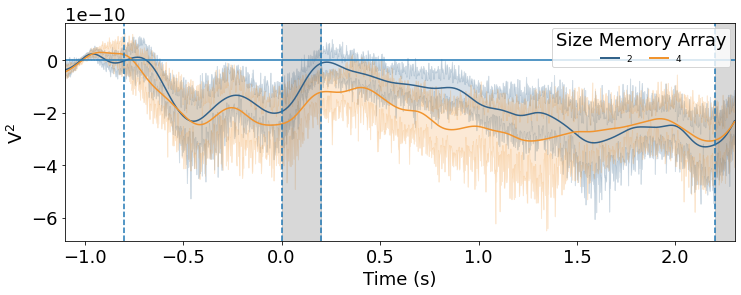

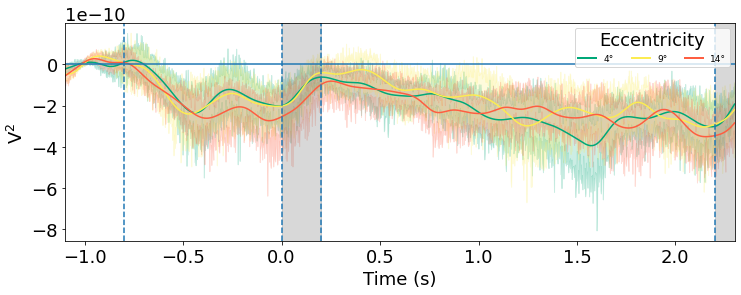

In [81]:
import matplotlib

#Plot main effect Load:
fig, ax = plt.subplots(1, figsize=(12,4))
plot_main_eff('Load', cond_dict, load_df_long, ax, n_boot=10) # <--- increase "n_boot" for better CIs (takes longer to run)
# Fake legend:
custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['LoadLow'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['LoadHigh'], lw=2)]
ax.legend(handles=custom_lines, title='Size Memory Array', labels=['2', '4'], loc=1, prop={'size': 9}, ncol=2)

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_load.svg')
fig.savefig(fname, bbox_inches="tight")

# Plot main effect Ecc:
fig, ax = plt.subplots(1, figsize=(12,4))
plot_main_eff('Ecc', cond_dict, ecc_df_long, ax, n_boot=10)
# Fake legend:
custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['EccS'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['EccM'], lw=2),
                matplotlib.lines.Line2D([0], [0], color=config.colors['EccL'], lw=2)]
ax.legend(handles=custom_lines, title='Eccentricity', labels=['4°', '9°', '14°'], 
          loc=1, prop={'size': 9}, ncol=3)

# Save it: 
fpath = op.join(config.paths["plots"], 'TFR', epo_part)
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'mainEff_ecc.svg')
fig.savefig(fname, bbox_inches="tight")

## ANOVA
We run a repeated measures ANOVA on the power values (averaged within the bilateral ROIs).
Mostly building on code from [this MNE tutorial](https://mne.tools/dev/auto_tutorials/stats-source-space/plot_stats_cluster_time_frequency_repeated_measures_anova.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-time-frequency-repeated-measures-anova-py).

In [82]:
#%% run rep-meas ANOVA on power: 

# building on code from: 
# https://mne.tools/dev/auto_tutorials/stats-source-space/plot_stats_cluster_time_frequency_repeated_measures_anova.html#sphx-glr-auto-tutorials-stats-source-space-plot-stats-cluster-time-frequency-repeated-measures-anova-py


#%%
df_list = list()
for load in cond_dict['Load']:
    for ecc in cond_dict['Ecc']:
        tfr_list = [load_avgtfr(subID, load+ecc, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                            -(config.times_dict['cue_dur']+0.1)), 
                    mode='percent') for subID in sub_list_str]


        diffs_ = [get_lateralized_power_difference(tfr, 
                                                config.chans_CDA_dict['Contra'], 
                                                config.chans_CDA_dict['Ipsi']) for 
                tfr in tfr_list]
        for d in diffs_:
            dat_ = d.crop(0.2, 2.2)
            df_list.append(dat_.data.mean(axis=0))
    times = dat_.times
    freqs = dat_.freqs
#%%

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vM

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vM

Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vMemEcc/Data2022/DataMNE/EEG/05_tfrs/induced/tfr_lists/fulllength/VME_S07-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: percent)
Reading /raven/ptmp/fklotzsche/Experiments/vM

In [83]:
# Setup parameters:
decim = 2
factor_levels = [2, 3]
effects = 'A*B'
n_levels = np.multiply(*factor_levels)
n_freqs = df_list[0].shape[-2]
n_times = df_list[0].shape[-1]
n_subs = int(len(df_list) / n_levels)

# Shape data matrix: subjects x effects x n_freqs*n_times
subtfr_array = np.asarray(df_list)
subtfr_mway_data = subtfr_array.reshape(n_levels, n_subs, n_freqs*n_times)
subtfr_mway_data = subtfr_mway_data.swapaxes(0, 1)

fvals, pvals = f_mway_rm(subtfr_mway_data, factor_levels, effects=effects)
effect_labels = ['Load', 'Ecc', 'Load x Ecc']

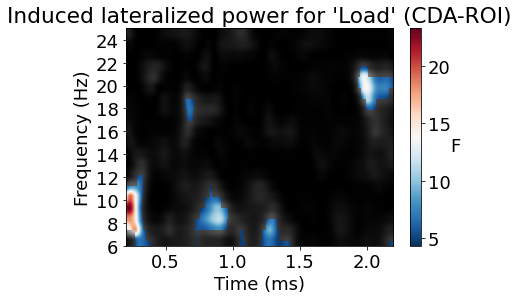

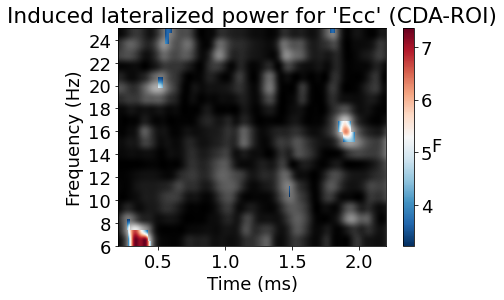

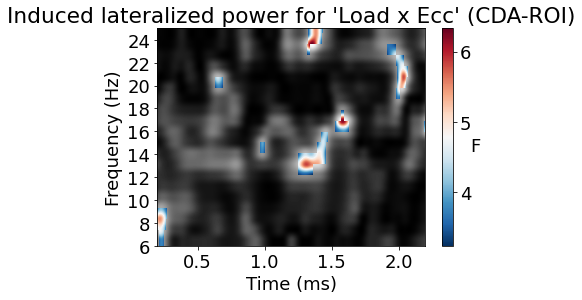

In [84]:
# Plot result:
for effect, sig, effect_label in zip(fvals, pvals, effect_labels):
    f = plt.figure()
    # show naive F-values in gray
    plt.imshow(effect.reshape(n_freqs, n_times), cmap=plt.cm.gray, extent=[times[0],
               times[-1], freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
    # create mask for significant Time-frequency locations
    effect[sig >= 0.05] = np.nan
    plt.imshow(effect.reshape(n_freqs, n_times), cmap='RdBu_r', extent=[times[0],
               times[-1], freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
    cb = plt.colorbar()
    cb.set_label(label='F', rotation=0)
    ytick_range = f.axes[0].get_ylim()
    ytick_vals = np.arange(*np.round(ytick_range), 2)
    f.axes[0].yaxis.set_ticks(ytick_vals)
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(r"Induced lateralized power for '%s' (%s)" % (effect_label, 'CDA-ROI'))
    plt.show()



stat_fun(H1): min=0.000000 max=23.240352
Running initial clustering
Found 28 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


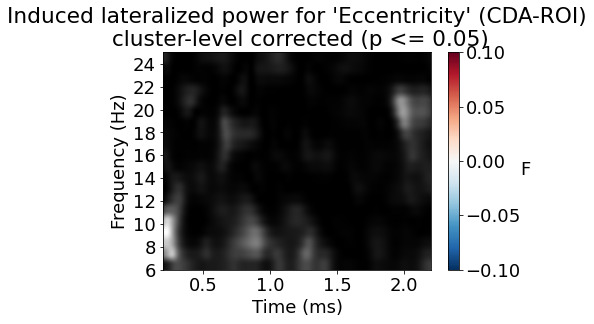

In [89]:
# Use CBP test to correct for multiple-comparisons correction:

# We need to do this separately for each effect:
effects='A'

effects_dict = {'A': 'Load',
                'B': 'Eccentricity',
                'A:B': 'Load x Eccentricity'}

def stat_fun(*args):
    return f_mway_rm(np.reshape(args, (len(sub_list), n_levels, n_freqs, len(times))), 
                     factor_levels=factor_levels,
                     effects=effects, return_pvals=False)[0]


# The ANOVA returns a tuple f-values and p-values, we will pick the former.
pthresh = 0.05  # set threshold rather high to save some time
f_thresh = f_threshold_mway_rm(len(sub_list), factor_levels, effects,
                               pthresh)
tail = 1  # f-test, so tail > 0
n_permutations = 1000  # Save some time (the test won't be too sensitive ...)
T_obs, clusters, cluster_p_values, h0 = mne.stats.permutation_cluster_test(
    subtfr_mway_data, stat_fun=stat_fun, threshold=f_thresh, tail=tail, n_jobs=-2,
    n_permutations=n_permutations, buffer_size=None, out_type='mask')

# Plot it:
T_obs_plot = np.ones_like(T_obs) *np.nan
for c, p in zip(clusters, cluster_p_values):
    if p < .05: 
        T_obs_plot[c] = T_obs[c]

f = plt.figure()
for f_image, cmap in zip([T_obs, T_obs_plot], [plt.cm.gray, 'RdBu_r']):
    plt.imshow(f_image.reshape(n_freqs, n_times), cmap=cmap, extent=[times[0], times[-1],
               freqs[0], freqs[-1]], aspect='auto',
               origin='lower')
cb = plt.colorbar()
cb.set_label(label='F', rotation=0)
ytick_range = f.axes[0].get_ylim()
ytick_vals = np.arange(*np.round(ytick_range), 2)
f.axes[0].yaxis.set_ticks(ytick_vals)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f"Induced lateralized power for {effects_dict[effects]} (%s)\n"
          " cluster-level corrected (p <= 0.05)" % 'CDA-ROI')

plt.show()